Please Note: in all the below algorithm I start the episode at random location. The algorithm shows much better performance when the start location is fixed.

# **Import Statement**

In [1]:
import gymnasium as gym
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# SARSA

I have implemented the following program to analyse SARSA algorithm performance over Frozen-Lake environment. There 10 independent run, and in each of these runs there are 500 segments, and in each of these segments there are 11 episode out of which, first 10 are training episodes, where we explore using softmax selection and update Q value table accordingly, and last 1 is the testing episode where we simply select the best action based on Greedy-Epsilon selection.

**Hyperparameters**

In my assignment 1, epsilon = 1-0.80 has shown the best results therefore, I used it here. gamma and discount_factor are choosen in a way that they are less than 1 but very close to 1

In [2]:
gamma = 0.99
discount_factor = 0.99
epsilon_sarsa = 0.20 # For greedy-epsilon algorithm

**Action Selection Functions**

In [3]:
"""
Choose action based on Softmax explotation policy given state and temp (temperature) 
"""
def choose_action_softmax(Q, state, temp):
    prob_q = {}
    valid_moves_list = [0, 1, 2, 3]
    for invalid_moves in get_invalid_moves(state):
        valid_moves_list.remove(invalid_moves)
    din = 0
    for valid in valid_moves_list:
        din = din + np.exp(Q[state][valid]/temp) 
    for valid in valid_moves_list:
        prob_q[valid] = np.exp(Q[state][valid]/temp) / din
    action = np.random.choice(valid_moves_list, p = list(prob_q.values()))
    return action, list(prob_q.values())

"""
Choose action based on Greedy Explotation policy given state and epsilon
"""
def choose_action_greedy(Q, state, epsilon = 0.85):
    prob_q = {}
    prob_q[0] = Q[state][0]
    prob_q[1] = Q[state][1]
    prob_q[2] = Q[state][2]
    prob_q[3] = Q[state][3]
    
    for invalid_moves in get_invalid_moves(state):
        prob_q.pop(invalid_moves)
    exploit = np.random.binomial(1, 1-epsilon)
    if exploit:
        return cal_max_key(prob_q)
    else:
        return np.random.choice(list(prob_q.keys()))
  
"""
Helper method 
for Greedy-epsilon
"""    
def cal_max_key(stats):
    max_val = 0
    for keys in stats:
        if max_val < stats[keys]:
            max_val = stats[keys]
    max_value_list = []
    for keys in stats:
        if max_val == stats[keys]:
            max_value_list.append(keys)
    return np.random.choice(max_value_list)

"""
Method to get list of invalid moves for the given state
Note: this methods is only valid for 4x4 map
"""
def get_invalid_moves(cur_position):
    if cur_position == 0:
        return [0, 3]
    elif cur_position == 4:
        return [2,3]
    elif cur_position == 12:
        return [0,1]
    elif cur_position == 15:
        return [1,2]
    elif cur_position in [1 , 2]:
        return [3]
    elif cur_position in [4 , 8]:
        return [0]
    elif cur_position in [7 , 11]:
        return [2]
    elif cur_position in [13 , 14]:
        return [1]
    else:
        return [] 

**Methods to analyse collected data (SARSA)**
<br>Question 1:
<br>I take the average of last 10 training episode returns and then , again, an average over 10 independent runs
<br>Question 2:
<br>I take the average of last testing episode return over 10 independent run.
<br>Question 3:
<br>I take the average of the entire 500 training episodes and average each episode return them over 10 independent run

In [4]:
"""
Question 1 
the effect of the parameters on the final training performance,
expressed as the return of the agent.
Averaged over the last 10 training episodes and the 10 runs
"""
def collect_data_1(data_dict):
    result_avg = 0
    for n_run in range(10):
        avg = 0
        for ind in range (10):
            avg = avg + data_dict[n_run]["training_data"][ind]
        avg = avg / 10
        result_avg = result_avg + avg
    result_avg = result_avg / 10
    return result_avg


"""
Question 2 
the effect of the parameters on the final testing performance,
expressed as the return of the agent.
During the final testing episode, averaged over the 10 runs
"""
def collect_data_2(data_dict): 
    result_avg = 0
    for n_run in range(10):
        result_avg = result_avg + data_dict[n_run]["testing_data"]
    result_avg = result_avg / 10
    return result_avg

"""
Question 3
Learning curves (mean and standard deviation computed based on the 10 runs) 
for the best parameter setting for each algorithm
"""
def collect_data_3(data_dict):
    main_dict_mean = np.zeros(5000, dtype = float)
    main_dict_sd = np.zeros(5000, dtype = float)
    for ind in range(5000):
        avg = []
        for n_run in range (10):
            avg.append(data_dict[n_run][ind])
        sd = np.std(avg)
        mean = np.mean(avg)
        main_dict_mean[ind] = mean
        main_dict_sd[ind] = sd
    return main_dict_mean, main_dict_sd

**Methods to Run the SARSA Algorithm**

In [5]:
"""
Run 10 episode of training with softmax exploration
Followed by 1 episode of testing with greedy exploration
"""
def run_epidodes_sarsa(Q, temp, alpha):
    training_reward_array = []
    for episode_n in range(10):
        # Data collection
        training_return = 0
        iter_n = 0
        # Starting
        start = env.reset()
        state = start[0]
        action, prob_array = choose_action_softmax(Q, state, temp)
        # loop variable
        done = False
        while not done:
            # Next state action and reward
            next_state_info = env.step(action)
            next_state = next_state_info[0]
            reward = next_state_info[1]
            done = next_state_info[2]
            next_action, next_prob_array = choose_action_softmax(Q, next_state, temp)
            
            #updating the Q value
            cur_state_value = Q[state, action]
            next_state_value = Q[next_state, next_action]
            target = reward + (gamma * next_state_value)
            Q[state, action] = Q[state, action] + alpha * (target - cur_state_value)
            
            # updating loop variable
            state = next_state
            action = next_action
            
            #Training data
            training_return = training_return + (reward * (pow(discount_factor,iter_n)))
            iter_n = iter_n + 1
        training_reward_array.append(training_return)
        
        
    testing_return = 0
    for episode_n in range(1):
        # Data collection
        iter_n = 0
        #N = np.zeros((16,4), dtype = float)
        # Starting
        start = env.reset()
        state = start[0]
        action = choose_action_greedy(Q, state, epsilon_sarsa)
        # Loop variablr
        done = False
        while not done:
            #Next state and action
            next_state_info = env.step(action)
            next_state = next_state_info[0]
            reward = next_state_info[1]
            done = next_state_info[2]
            next_action = choose_action_greedy(Q, next_state, epsilon_sarsa)
            
            # updating loop variable
            state = next_state
            action = next_action
            
            #testing data
            testing_return = testing_return + (reward * (discount_factor ** iter_n))
            iter_n = iter_n + 1
            
    return training_reward_array, testing_return, Q
        
"""
Run 500 segments
"""   
def run_segments_sarsa(Q, temp, alpha):
    main_dict = {}
    all_ep = []
    for n in range(0,500):
        train_r, test_r, Q = run_epidodes_sarsa(Q, temp, alpha)
        all_ep = all_ep + train_r
        if n == 499:
            main_dict = {"training_data": train_r, "testing_data": test_r}
    return main_dict, all_ep

"""
Run 10 independent runs
"""  
def run_algo_sarsa(temp, alpha):
    final_ep_dict = {}
    all_ep = {}
    for n in range(0,10):
        Q = np.zeros((16,4), dtype = float)
        final_ep_data, all_ep_data = run_segments_sarsa(Q, temp, alpha)
        final_ep_dict[n] = final_ep_data
        all_ep[n] = all_ep_data
    print("Independent Run Completed")
    return final_ep_dict, all_ep

**Collecting data for analysis (SARSA)**

Now the temperature values are 0.25, 0.01 and 0.005 and alpha values are 1/4, 1/8 and 1/16
<br>Alpha values are choosen to be similar to q2 of this assignments.

In [6]:
sarsa_data_dict_0, sarsa_all_epi_0 = run_algo_sarsa(0.250, 1/4) 
sarsa_data_dict_1, sarsa_all_epi_1 = run_algo_sarsa(0.250, 1/8) 
sarsa_data_dict_2, sarsa_all_epi_2 = run_algo_sarsa(0.250, 1/16)
sarsa_data_dict_3, sarsa_all_epi_3 = run_algo_sarsa(0.100, 1/4)
sarsa_data_dict_4, sarsa_all_epi_4 = run_algo_sarsa(0.100, 1/8)
sarsa_data_dict_5, sarsa_all_epi_5 = run_algo_sarsa(0.100, 1/16) 
sarsa_data_dict_6, sarsa_all_epi_6 = run_algo_sarsa(0.005, 1/4) 
sarsa_data_dict_7, sarsa_all_epi_7 = run_algo_sarsa(0.005, 1/8)
sarsa_data_dict_8, sarsa_all_epi_8 = run_algo_sarsa(0.005, 1/16)

Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed


**Plot for last 10 training episodes for fixed values of temperature**

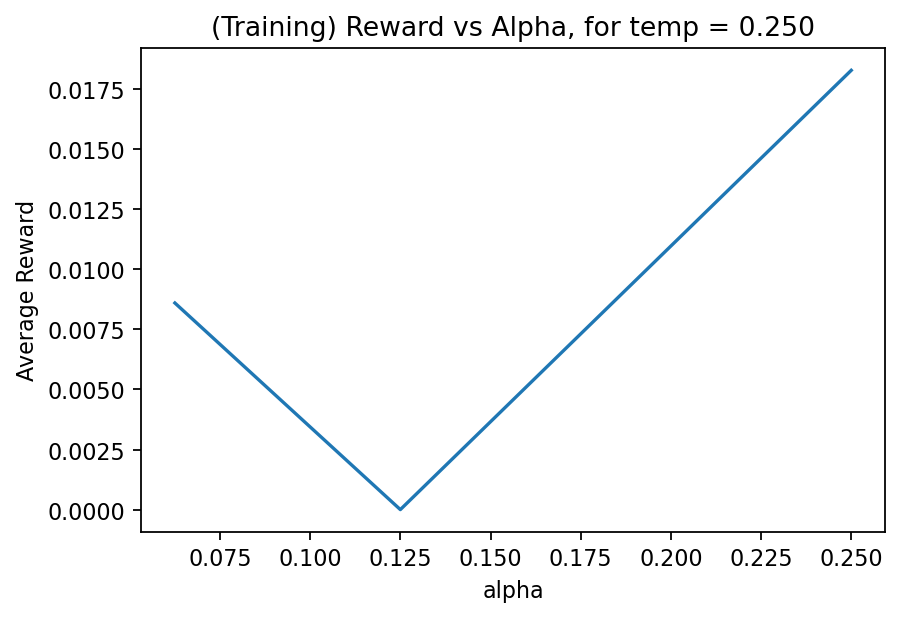

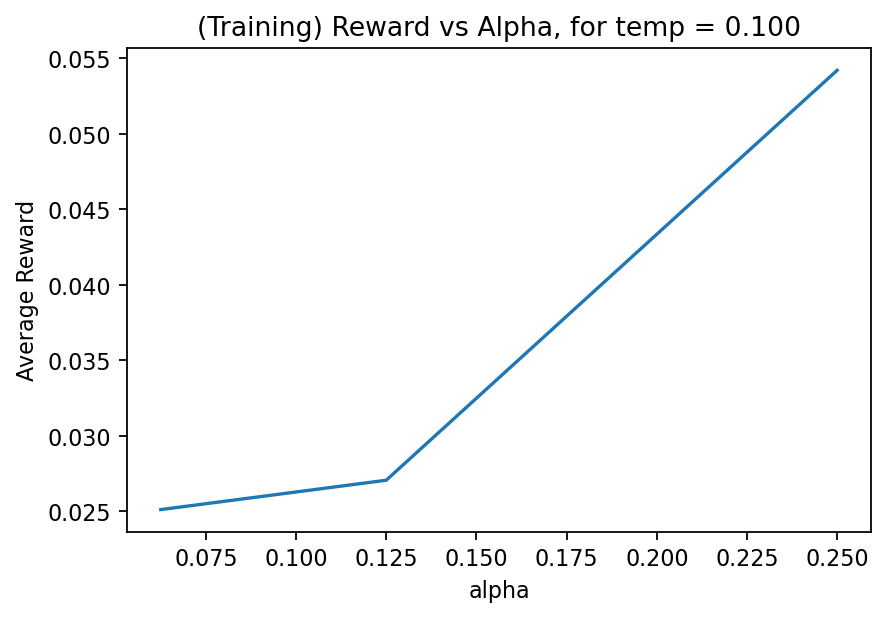

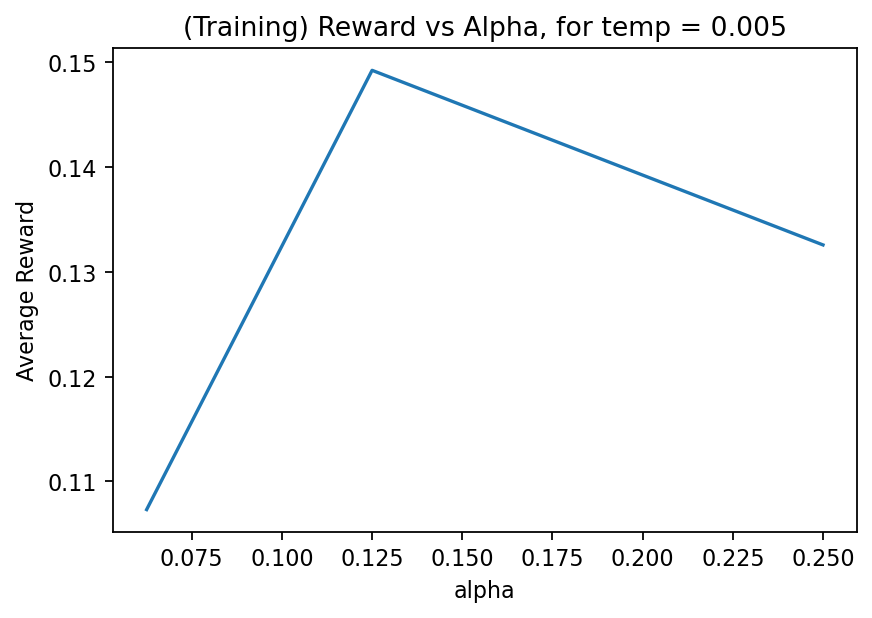

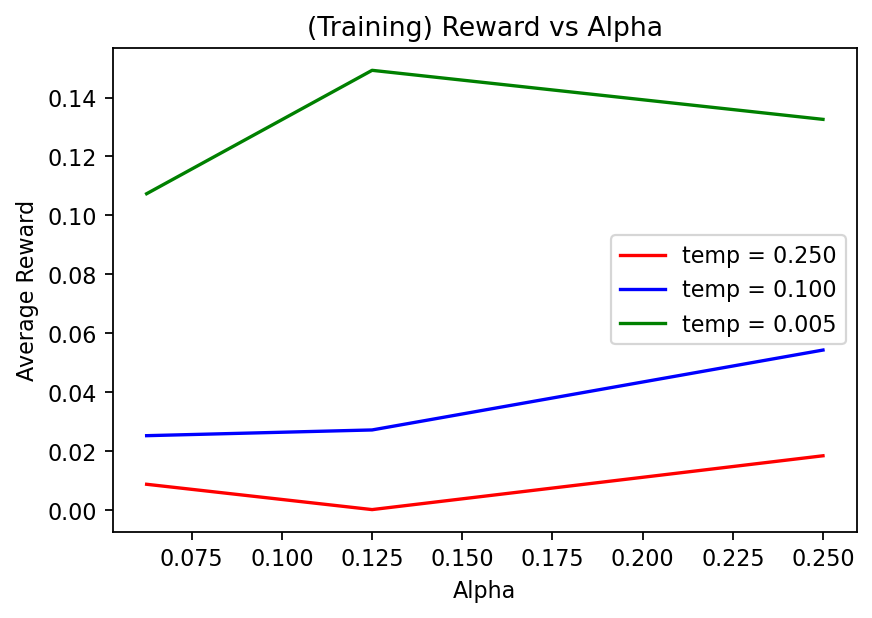

In [7]:
x_axis = []
x_axis.append(1/4)
x_axis.append(1/8)
x_axis.append(1/16)

y_axis_0 = []
y_axis_0.append(collect_data_1(sarsa_data_dict_0))
y_axis_0.append(collect_data_1(sarsa_data_dict_1))
y_axis_0.append(collect_data_1(sarsa_data_dict_2))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.250")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_1(sarsa_data_dict_3))
y_axis_1.append(collect_data_1(sarsa_data_dict_4))
y_axis_1.append(collect_data_1(sarsa_data_dict_5))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.100")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_1(sarsa_data_dict_6))
y_axis_2.append(collect_data_1(sarsa_data_dict_7))
y_axis_2.append(collect_data_1(sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.005")
plt.show()


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r')
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['temp = 0.250','temp = 0.100','temp = 0.005'])
plt.xlabel("Alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha")
plt.show()

<br>When 
    <br>temp = 0.25: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/8
    <br>temp = 0.10: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/16
    <br>temp = 0.05: we recieved the highest return at alpha = 1/8 and lowest at alpha = 1/16
<br>We this details we could say that the prefered value of alpha should be alpha = 1/4. Now, when we compare all the three graphs together we see that highest return is at alpha = 1/8 and temp = 0.005

**Plot for last 10 training episodes for fixed values of alpha**

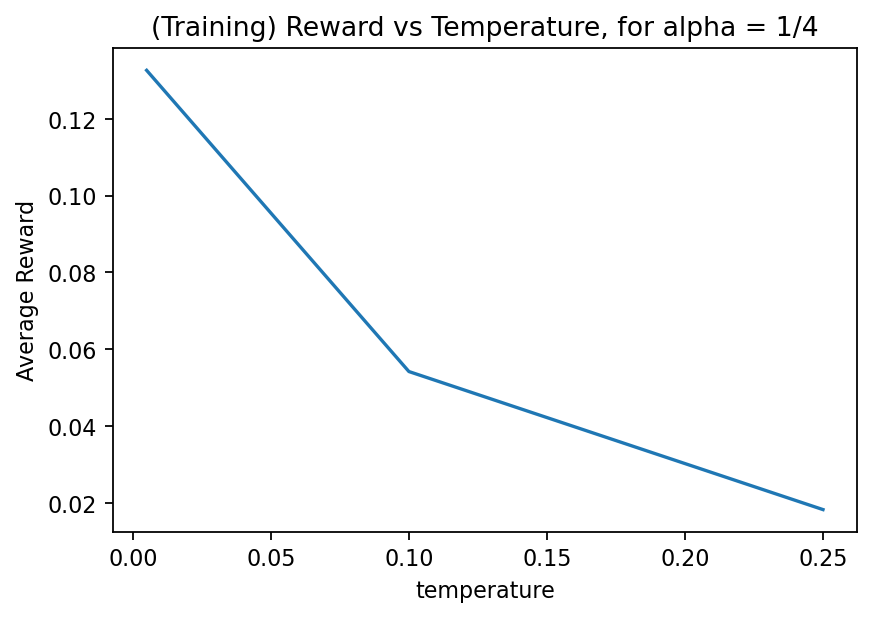

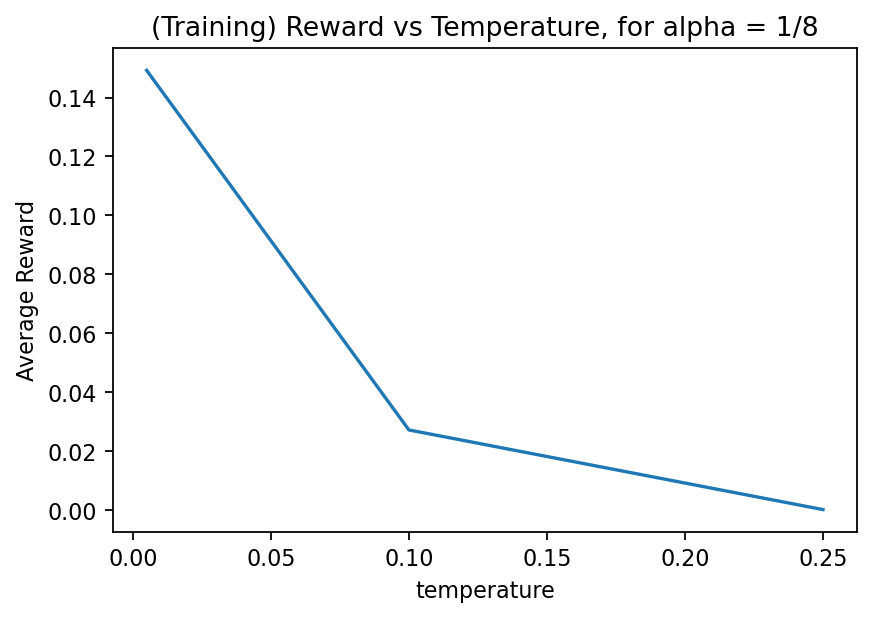

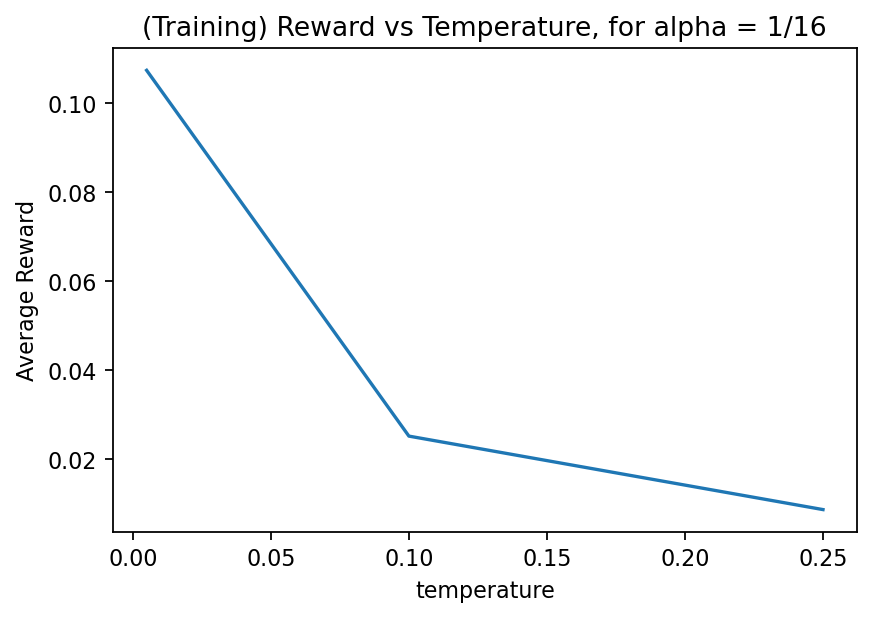

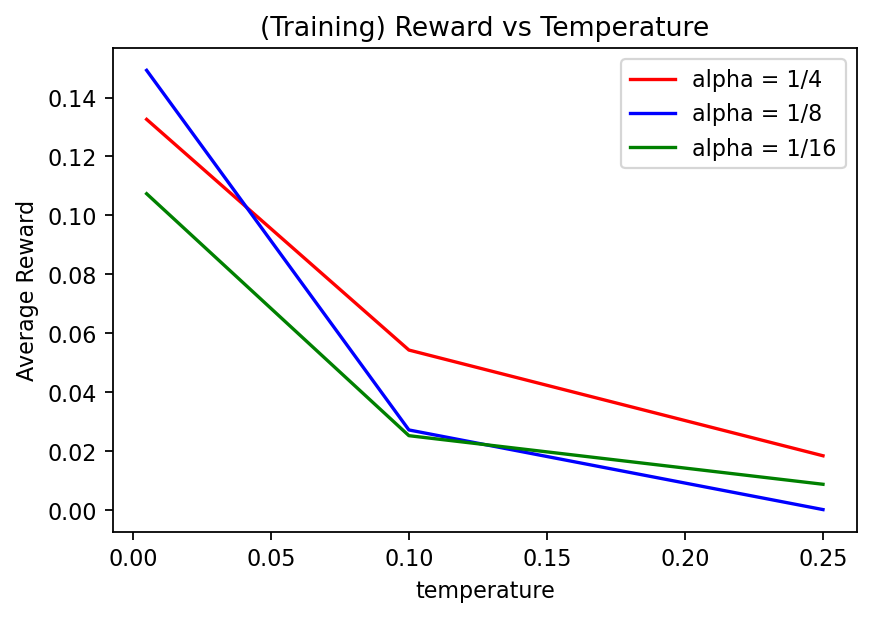

In [8]:
x_axis = []
x_axis.append(0.250)
x_axis.append(0.100)
x_axis.append(0.005)

y_axis_0 = []
y_axis_0.append(collect_data_1(sarsa_data_dict_0))
y_axis_0.append(collect_data_1(sarsa_data_dict_3))
y_axis_0.append(collect_data_1(sarsa_data_dict_6))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/4")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_1(sarsa_data_dict_1))
y_axis_1.append(collect_data_1(sarsa_data_dict_4))
y_axis_1.append(collect_data_1(sarsa_data_dict_7))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/8")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_1(sarsa_data_dict_2))
y_axis_2.append(collect_data_1(sarsa_data_dict_5))
y_axis_2.append(collect_data_1(sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/16")
plt.show()

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r') 
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['alpha = 1/4','alpha = 1/8','alpha = 1/16'])
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature")
plt.show()


When 
    <br>alpha = 1/4: we recieved the highest return at temp = 0.005 and lowest at temp = 0.250
    <br>alpha = 1/8: we recieved the highest return at temp = 0.005 and lowest at temp = 0.250
    <br>alpha = 1/16: we recieved the highest return at temp = 0.005 and temp = 0.250 and lowest at temp = 0.25
<br>We this details we could say that the prefered value of temp should be temp = 0.005. Now, when we compare all the graphs together we see that the highest return was observed at alpha = 1/8 and temp = 0.005

**Plot for last testing episodes for fixed values of temp**

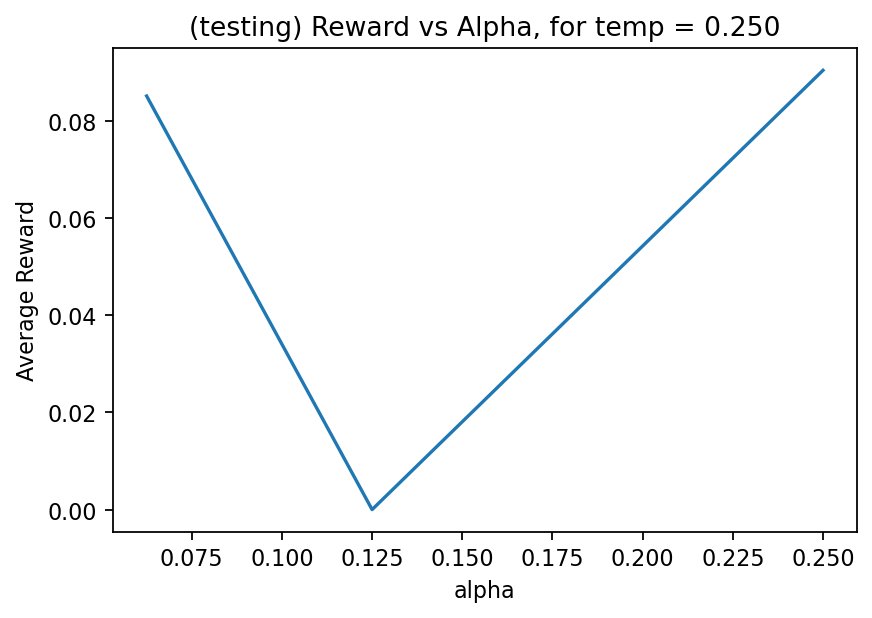

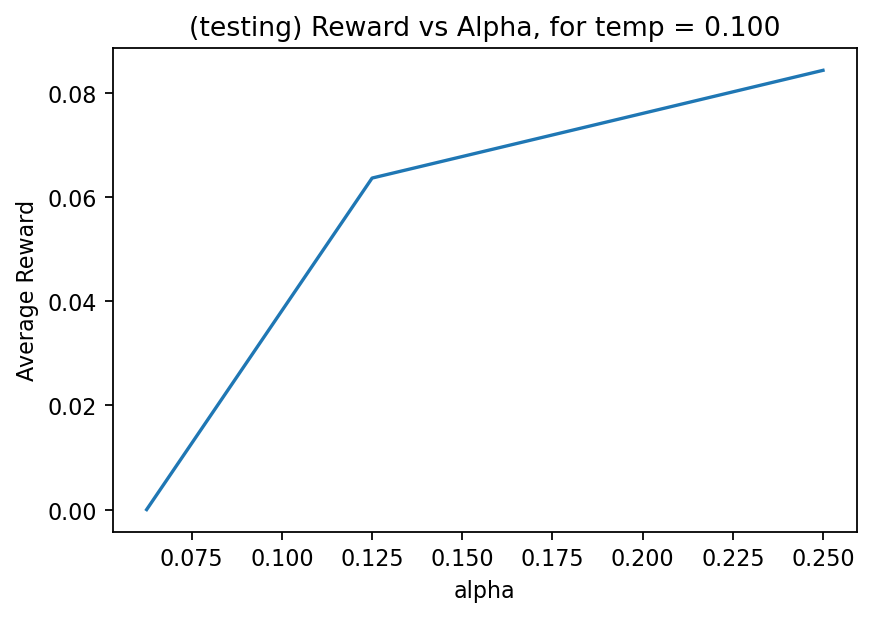

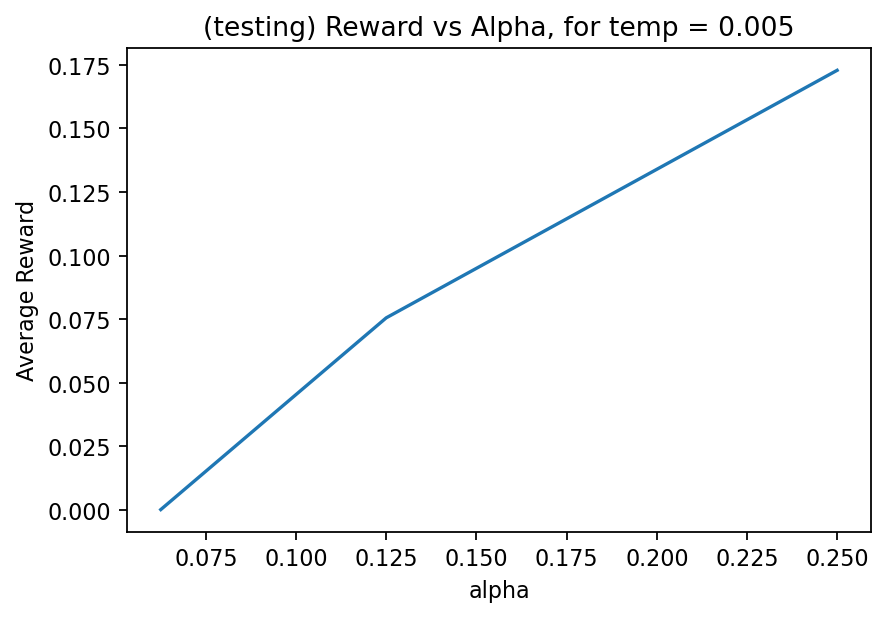

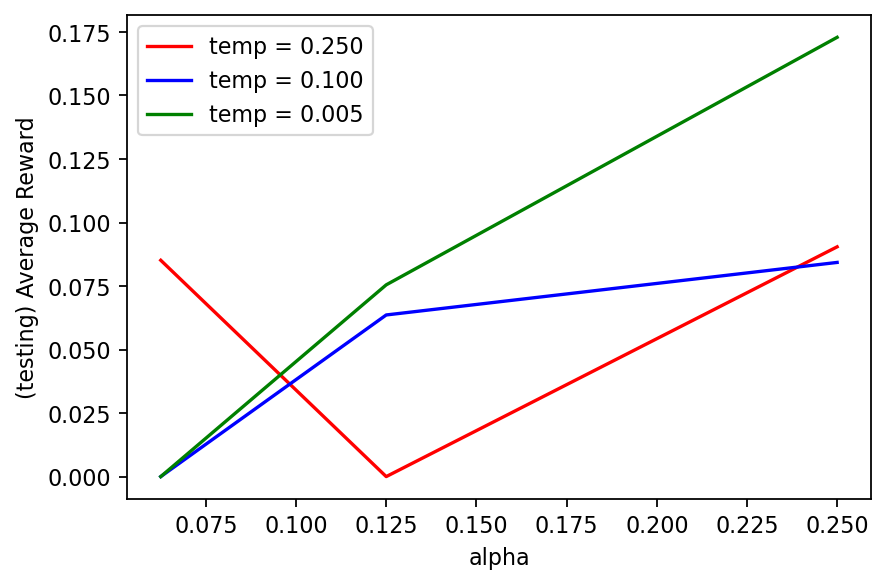

In [9]:
x_axis = []
x_axis.append(1/4)
x_axis.append(1/8)
x_axis.append(1/16)

y_axis_0 = []
y_axis_0.append(collect_data_2(sarsa_data_dict_0))
y_axis_0.append(collect_data_2(sarsa_data_dict_1))
y_axis_0.append(collect_data_2(sarsa_data_dict_2))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(testing) Reward vs Alpha, for temp = 0.250")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_2(sarsa_data_dict_3))
y_axis_1.append(collect_data_2(sarsa_data_dict_4))
y_axis_1.append(collect_data_2(sarsa_data_dict_5))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(testing) Reward vs Alpha, for temp = 0.100")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_2(sarsa_data_dict_6))
y_axis_2.append(collect_data_2(sarsa_data_dict_7))
y_axis_2.append(collect_data_2(sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(testing) Reward vs Alpha, for temp = 0.005")
plt.show()


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r') 
plt.plot(x_axis, y_axis_1, 'b') 
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['temp = 0.250','temp = 0.100','temp = 0.005'])
plt.xlabel("alpha")
plt.ylabel("(testing) Average Reward")
plt.show()

<br>When 
    <br>temp = 0.25: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/8
    <br>temp = 0.10: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/16
    <br>temp = 0.05: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/8
<br>We this details we could say that the prefered value of alpha should be alpha = 1/16. Now, when we compare all the three graphs together we see that highest return is at alpha = 1/4 and temp = 0.005

**Plot for last testing episodes for fixed values of alpha**

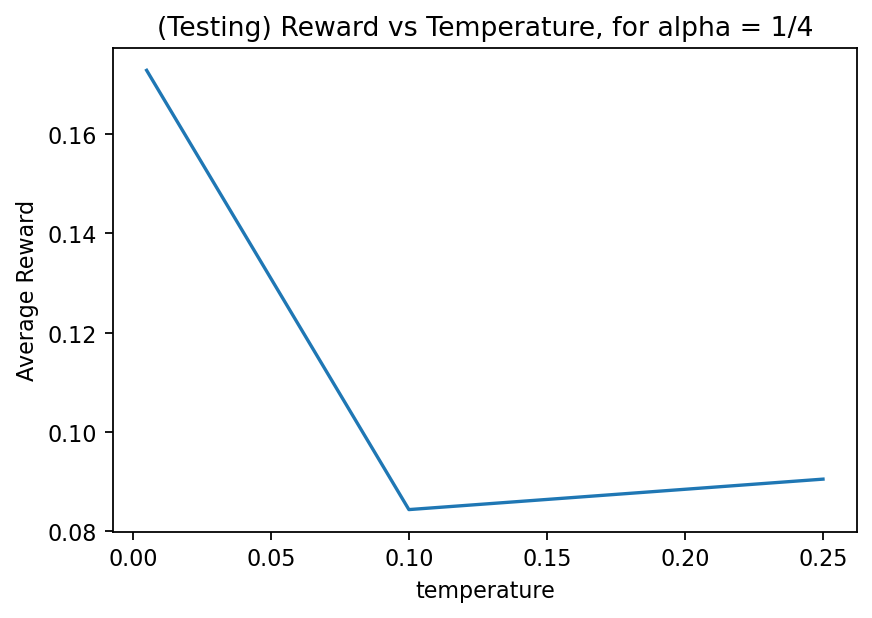

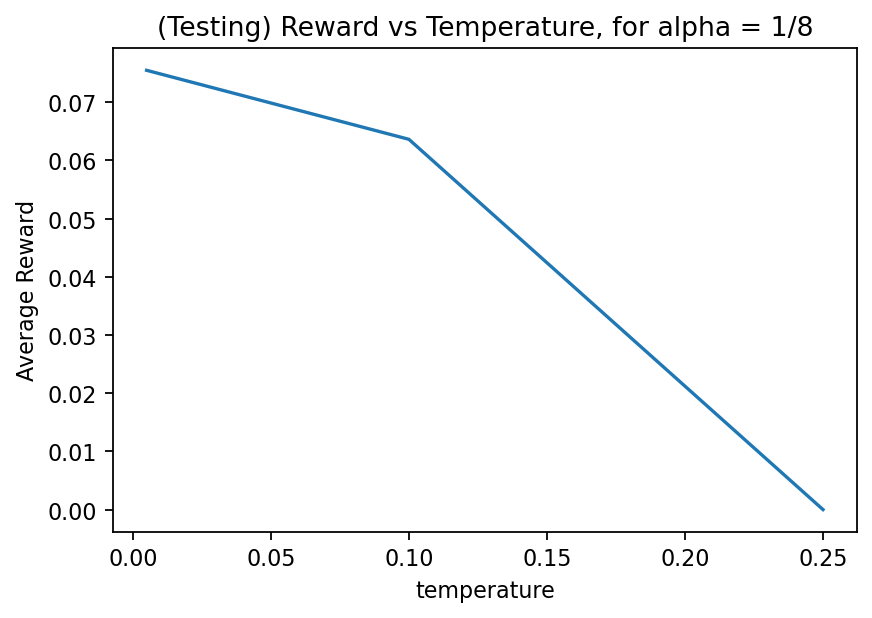

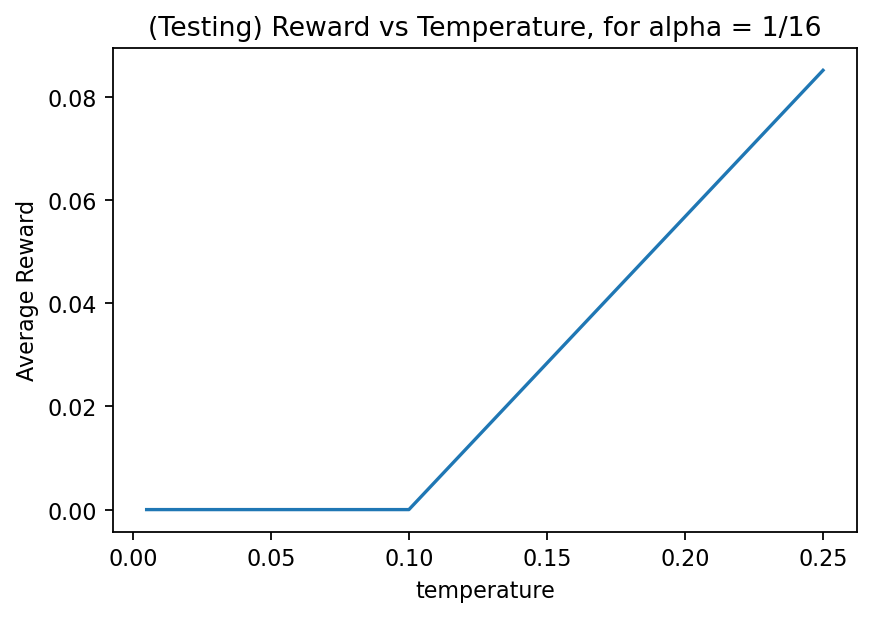

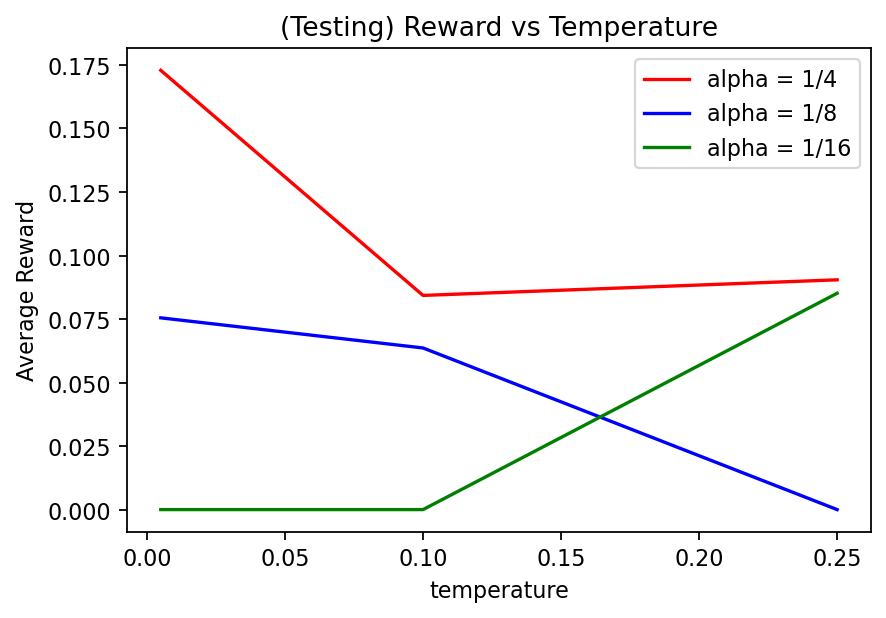

In [10]:
x_axis = []
x_axis.append(0.250)
x_axis.append(0.100)
x_axis.append(0.005)

y_axis_0 = []
y_axis_0.append(collect_data_2(sarsa_data_dict_0))
y_axis_0.append(collect_data_2(sarsa_data_dict_3))
y_axis_0.append(collect_data_2(sarsa_data_dict_6))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/4")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_2(sarsa_data_dict_1))
y_axis_1.append(collect_data_2(sarsa_data_dict_4))
y_axis_1.append(collect_data_2(sarsa_data_dict_7))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/8")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_2(sarsa_data_dict_2))
y_axis_2.append(collect_data_2(sarsa_data_dict_5))
y_axis_2.append(collect_data_2(sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/16")
plt.show()


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r') 
plt.plot(x_axis, y_axis_1, 'b') 
plt.plot(x_axis, y_axis_2, 'g')
plt.legend(['alpha = 1/4','alpha = 1/8','alpha = 1/16'])
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature")
plt.show()


<br>When 
    <br>alpha = 1/4: we recieved the highest return at temp = 0.005 and lowest at temp = 0.100
    <br>alpha = 1/8: we recieved the highest return at temp = 0.005 and lowest at temp = 0.005
    <br>alpha = 1/16: we recieved the highest return at temp = 0.005 and temp = 0.100 and temp = 0.005
<br>We this details we could say that the prefered value of temp should be temp = 0.005. Now, when we compare all the graphs together we see that the highest return was observed at alpha = 1/4 and temp = 0.005

**Plot for the entire training episodes with best observed parameters**

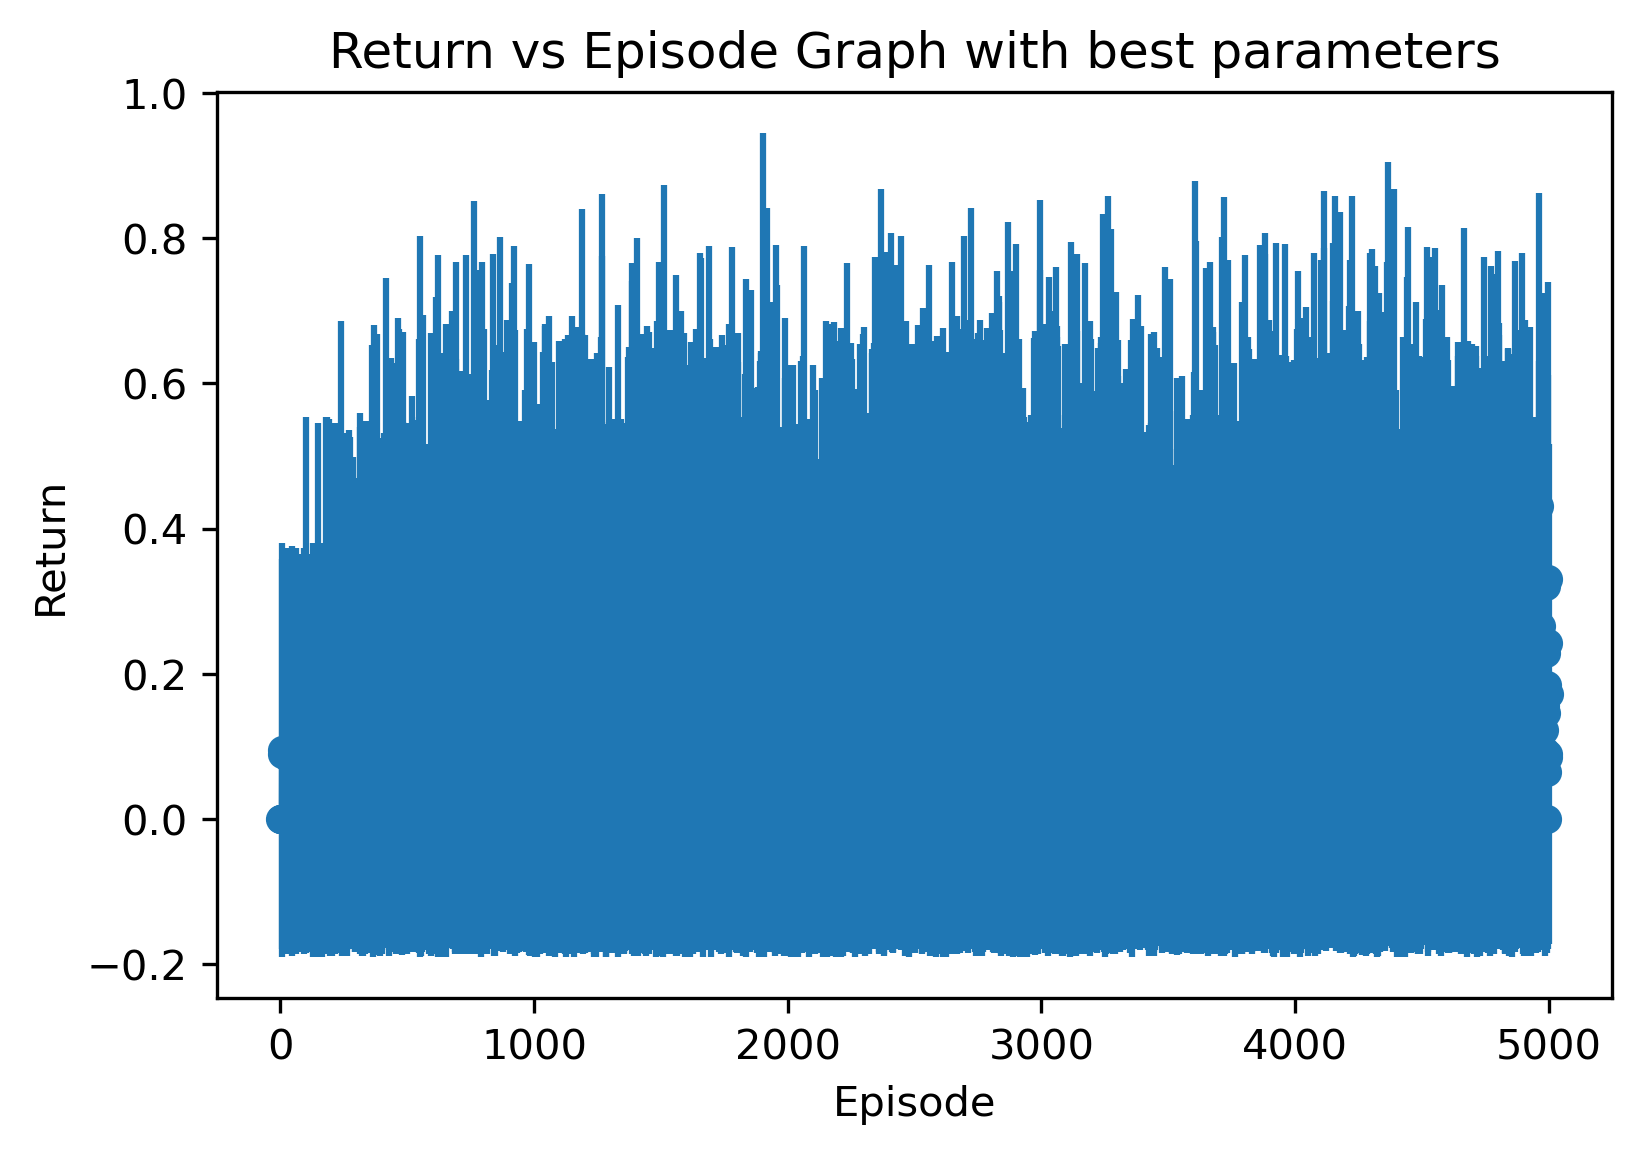

In [31]:
mean_array, sd_array = collect_data_3(sarsa_all_epi_7)
x = list(range(len(mean_array)))

plt.figure(dpi=300)
plt.errorbar(x, mean_array, yerr=sd_array, fmt='-o')
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode Graph with best parameters")
plt.show()

In the entire training graph (500^10) with the best parameters (i.e. temp = 0.05 and alpha = 1/8) we obeserve that the average episode's return increases slighly till around 1000th episode (from 0 to 0.50) before it converges to a value and then it remains the same.

# **Expected SARSA**

Similar to sarsa, I am implemented program to analyse Expected SARSA algorithm performance over Frozen-Lake environment.  The only difference is we expect the next action value instead of true value. Again there 10 independent run, and in each of these runs there are 500 segments, and in each of these segments there are 11 episode out of which, first 10 are training episode, where we explore using softmax selection and update Q value table, and 1 testing episode where we simply select the best action based on Greedy Epsilon selection. 

gamma, discount_factor and epsilon are same as SARSA

methods to analyse collected data are also same as SARSA

**Methods to Run the Expected SARSA Algorithm**

In [12]:
"""
Run 10 episode of training with softmax exploration
Followed by 1 episode of testing with greedy exploration
"""
def run_epidodes_sarsa_expected(Q, temp, alpha):
    training_reward_array = []
    for episode_n in range(0,10):
        # Data collection
        training_return = 0
        iter_n = 0
        # Starting
        start = env.reset()
        state = start[0]
        action, prob_array = choose_action_softmax(Q, state, temp)
        # loop variable
        done = False
        while not done:
            # Next state action and reward
            next_state_info = env.step(action)
            next_state = next_state_info[0]
            reward = next_state_info[1]
            done = next_state_info[2]
            next_action, prob_array_next = choose_action_softmax(Q, next_state, temp)
            
            #updating the Q value
            cur_state_value = Q[state, action]
            next_state_value = get_sarsa_expectation(Q, next_state, prob_array_next)
            target = reward + (gamma * next_state_value)
            Q[state, action] = Q[state, action] + alpha * (target - cur_state_value)
            
            # updating loop variable
            state = next_state
            action = next_action
            
            #Training data
            training_return = training_return + (reward * (pow(discount_factor,iter_n)))
            iter_n = iter_n + 1
        training_reward_array.append(training_return)
        
        
    testing_return = 0
    for episode_n in range(1):
        # Data collection
        iter_n = 0
        # Starting
        start = env.reset()
        state = start[0]
        action = choose_action_greedy(Q, state, epsilon_sarsa)
        # Loop variablr
        done = False
        while not done:
            #Next state and action
            next_state_info = env.step(action)
            next_state = next_state_info[0]
            reward = next_state_info[1]
            done = next_state_info[2]
            next_action = choose_action_greedy(Q, next_state, epsilon_sarsa)
            
            # updating loop variable
            state = next_state
            action = next_action
            
            #testing data
            testing_return = testing_return + (reward * (discount_factor ** iter_n))
            iter_n = iter_n + 1
            
    return training_reward_array, testing_return, Q
        
"""
Run 500 segments
"""
def run_segments_sarsa_expected(Q, temp, alpha):
    main_dict = {}
    all_ep = []
    for n in range(0,500):
        train_r, test_r, Q = run_epidodes_sarsa_expected(Q, temp, alpha)
        all_ep = all_ep + train_r
        if n == 499:
            main_dict = {"training_data": train_r, "testing_data": test_r}
    return main_dict, all_ep

"""
Run 10 independent runs
"""
def run_algo_sarsa_expected(temp, alpha):
    final_ep_dict = {}
    all_ep = {}
    for n in range(0,10):
        Q = np.zeros((16,4), dtype = float)
        final_ep_data, all_ep_data = run_segments_sarsa_expected(Q, temp, alpha)
        final_ep_dict[n] = final_ep_data
        all_ep[n] = all_ep_data
    print("Independent Run Completed")
    return final_ep_dict, all_ep
    
"""
Function to get expectation of next state value
"""    
def get_sarsa_expectation(Q, state, prob_array_next):
    return_sum = 0
    invalid_moves = get_invalid_moves(state)
    n = 0
    for i in range(4):
        if i not in invalid_moves:
            return_sum = return_sum + Q[state,i] * prob_array_next[n]
            n = n + 1
    return return_sum / max(1,n)

**Collecting data for Expected SARSA**

Now the temperature values are 0.25, 0.01 and 0.005 and alpha values are 1/4, 1/8 and 1/16
Alpha values are choosen to be similar to q2 of this assignments.

In [13]:
expected_sarsa_data_dict_0, expected_sarsa_all_epi_0 = run_algo_sarsa_expected(0.250, 1/4)
expected_sarsa_data_dict_1, expected_sarsa_all_epi_1 = run_algo_sarsa_expected(0.250, 1/8)
expected_sarsa_data_dict_2, expected_sarsa_all_epi_2 = run_algo_sarsa_expected(0.250, 1/16)
expected_sarsa_data_dict_3, expected_sarsa_all_epi_3 = run_algo_sarsa_expected(0.100, 1/4)
expected_sarsa_data_dict_4, expected_sarsa_all_epi_4 = run_algo_sarsa_expected(0.100, 1/8)
expected_sarsa_data_dict_5, expected_sarsa_all_epi_5 = run_algo_sarsa_expected(0.100, 1/16)
expected_sarsa_data_dict_6, expected_sarsa_all_epi_6 = run_algo_sarsa_expected(0.005, 1/4)
expected_sarsa_data_dict_7, expected_sarsa_all_epi_7 = run_algo_sarsa_expected(0.005, 1/8)
expected_sarsa_data_dict_8, expected_sarsa_all_epi_8 = run_algo_sarsa_expected(0.005, 1/16)

Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed
Independent Run Completed


**Plot graph for last 10 training episodes (Expected SARSA)**

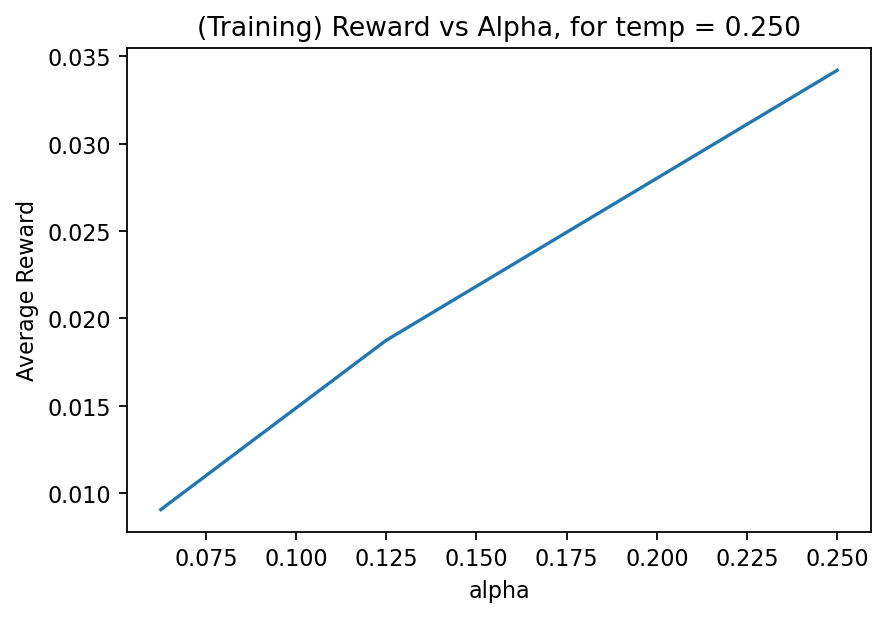

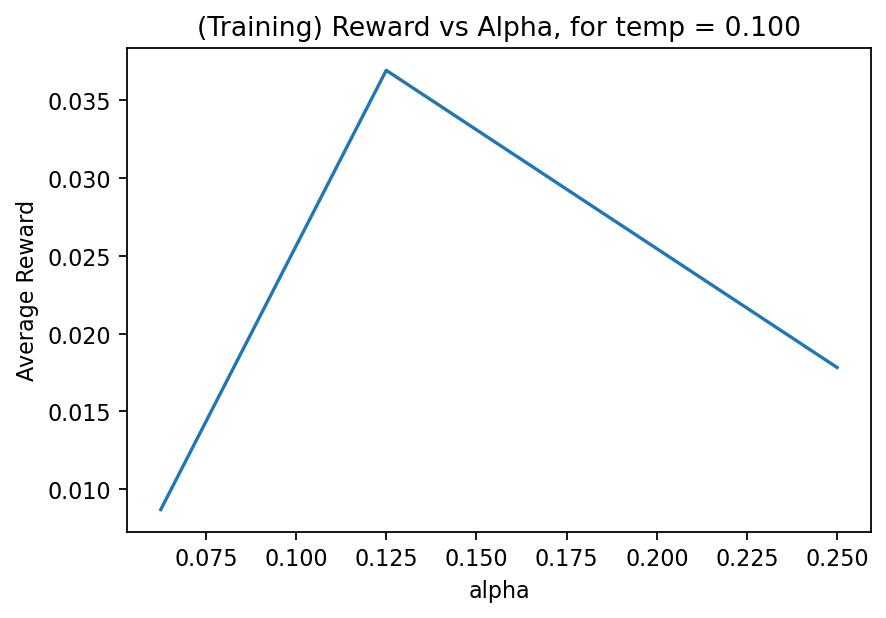

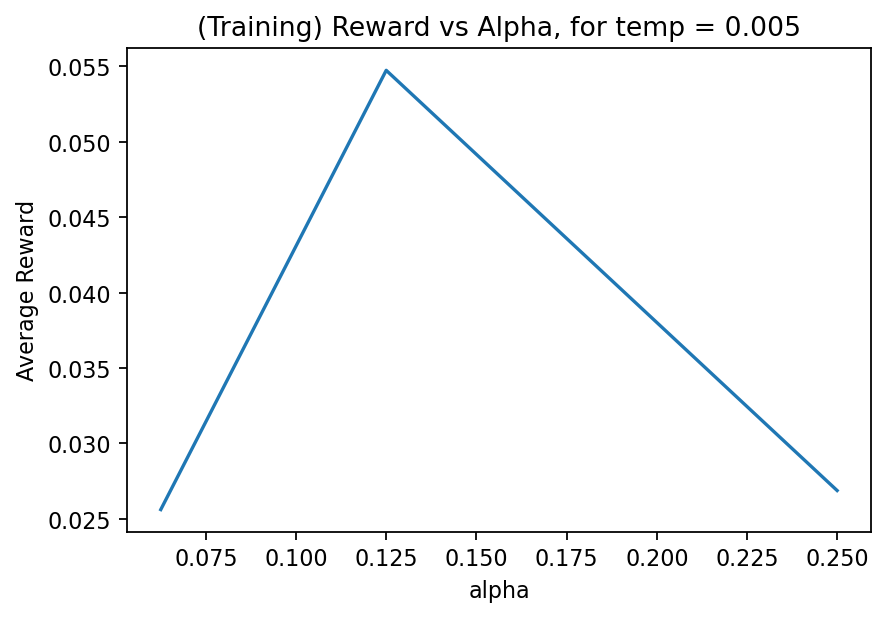

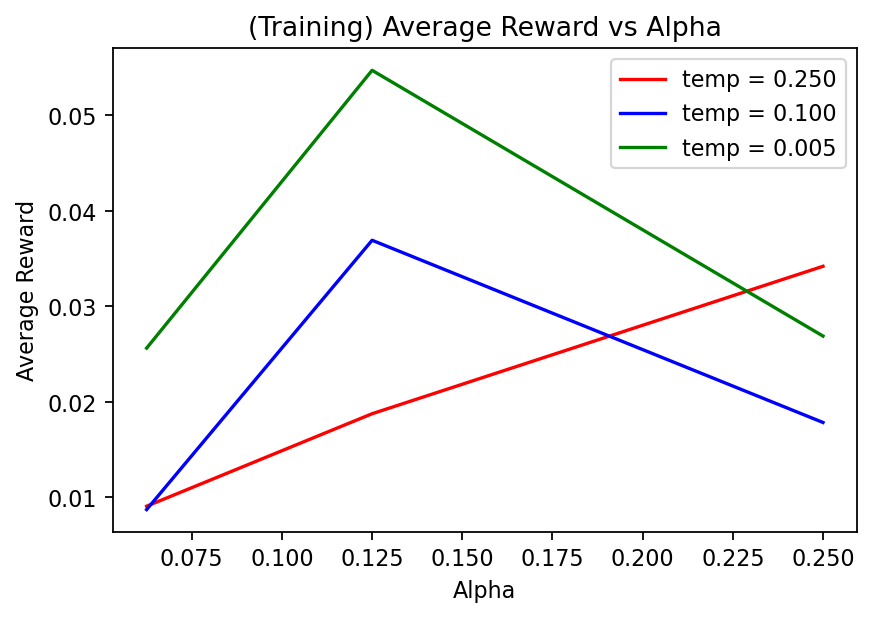

In [14]:
x_axis = []
x_axis.append(1/4)
x_axis.append(1/8)
x_axis.append(1/16)

y_axis_0 = []
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_0))
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_1))
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_2))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.250")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_3))
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_4))
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_5))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.100")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_6))
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_7))
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Alpha, for temp = 0.005")
plt.show()


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r')
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['temp = 0.250','temp = 0.100','temp = 0.005'])
plt.xlabel("Alpha")
plt.ylabel("Average Reward")
plt.title("(Training) Average Reward vs Alpha")
plt.show()

<br>When 
    <br>temp = 0.25: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/16
    <br>temp = 0.10: we recieved the highest return at alpha = 1/8 and lowest at alpha = 1/16
    <br>temp = 0.05: we recieved the highest return at alpha = 1/8 and lowest at alpha = 1/16
<br>We this details we could say that the prefered value of alpha should be alpha = 1/8. Now, when we compare all the three graphs together we see that highest return is at alpha = 1/8 and temp = 0.005

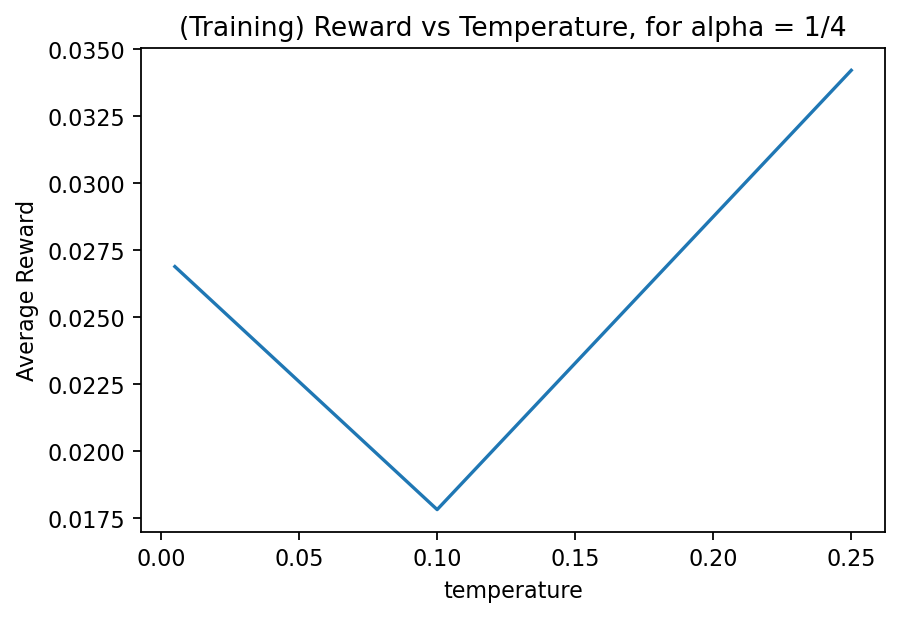

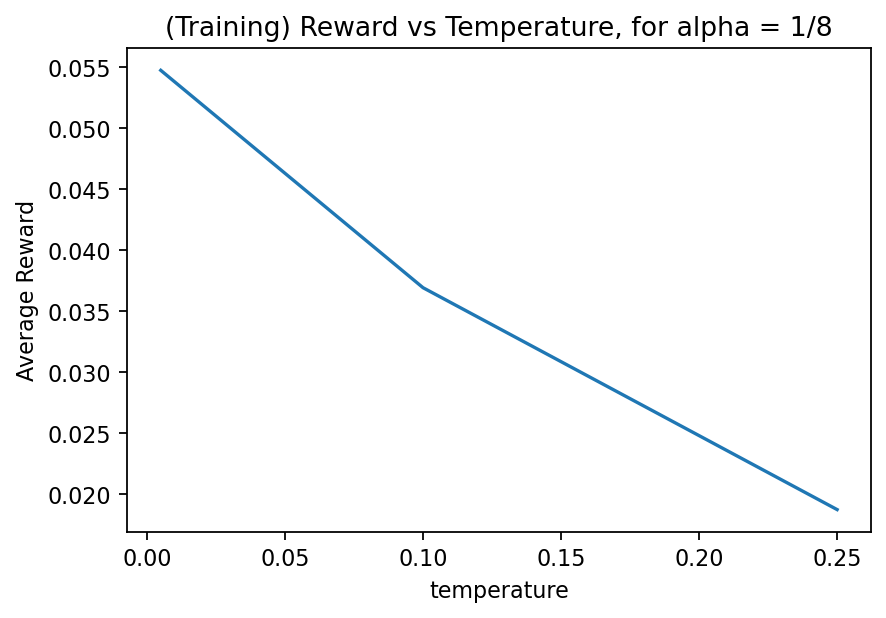

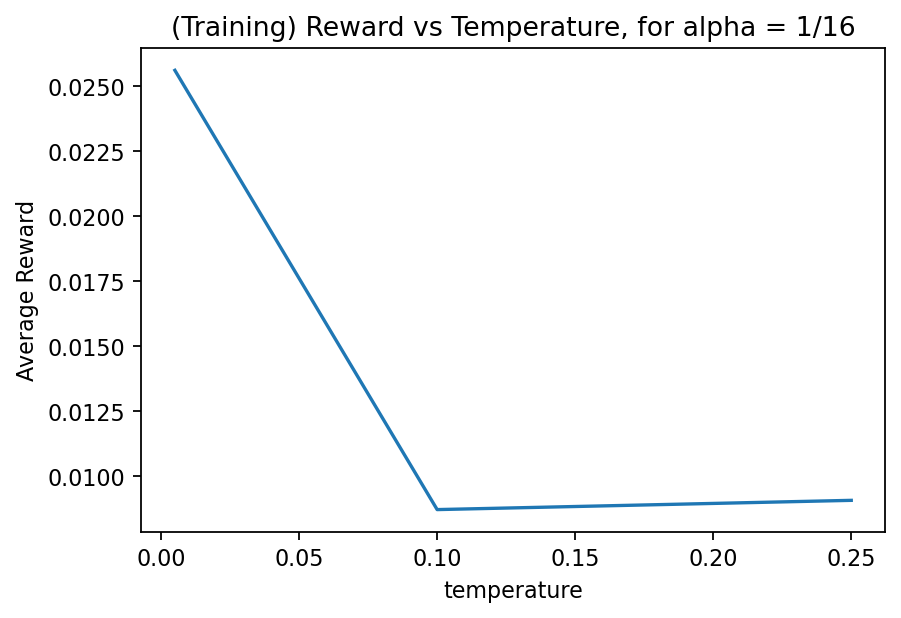

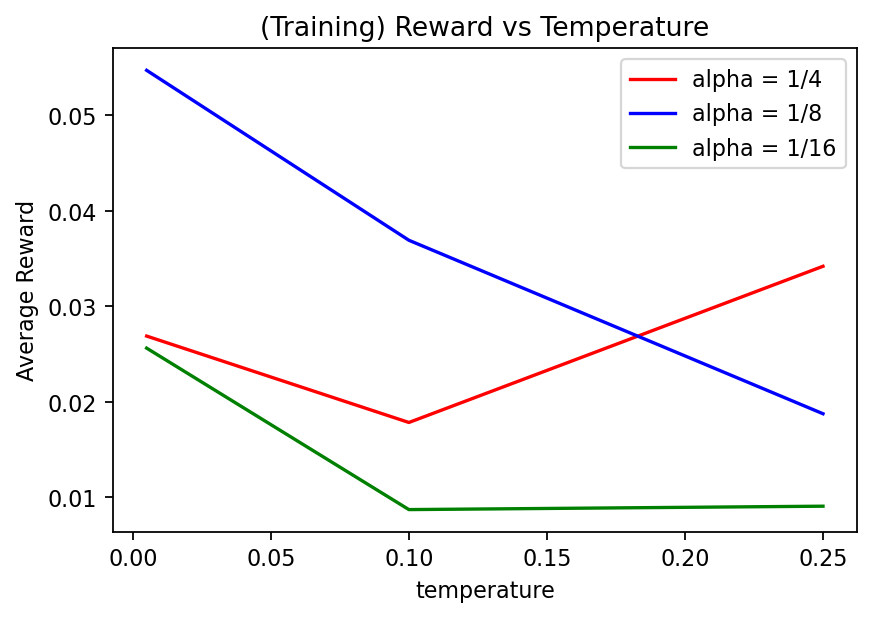

In [15]:
x_axis = []
x_axis.append(0.250)
x_axis.append(0.100)
x_axis.append(0.005)

y_axis_0 = []
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_0))
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_3))
y_axis_0.append(collect_data_1(expected_sarsa_data_dict_6))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/4")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_1))
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_4))
y_axis_1.append(collect_data_1(expected_sarsa_data_dict_7))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/8")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_2))
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_5))
y_axis_2.append(collect_data_1(expected_sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature, for alpha = 1/16")
plt.show()

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r') 
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['alpha = 1/4','alpha = 1/8','alpha = 1/16'])
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Training) Reward vs Temperature")
plt.show()

<br>When 
    <br>alpha = 1/4: we recieved the highest return at temp = 0.250 and lowest at temp = 0.100
    <br>alpha = 1/8: we recieved the highest return at temp = 0.005 and lowest at temp = 0.250
    <br>alpha = 1/16: we recieved the highest return at temp = 0.250 and temp = 0.100
<br>We this details we could say that the prefered value of temp should be temp = 0.250. Now, when we compare all the graphs together we see that the highest return was observed at alpha = 1/8 and temp = 0.005

**Plot graph for last testing episodes (Expected SARSA)**

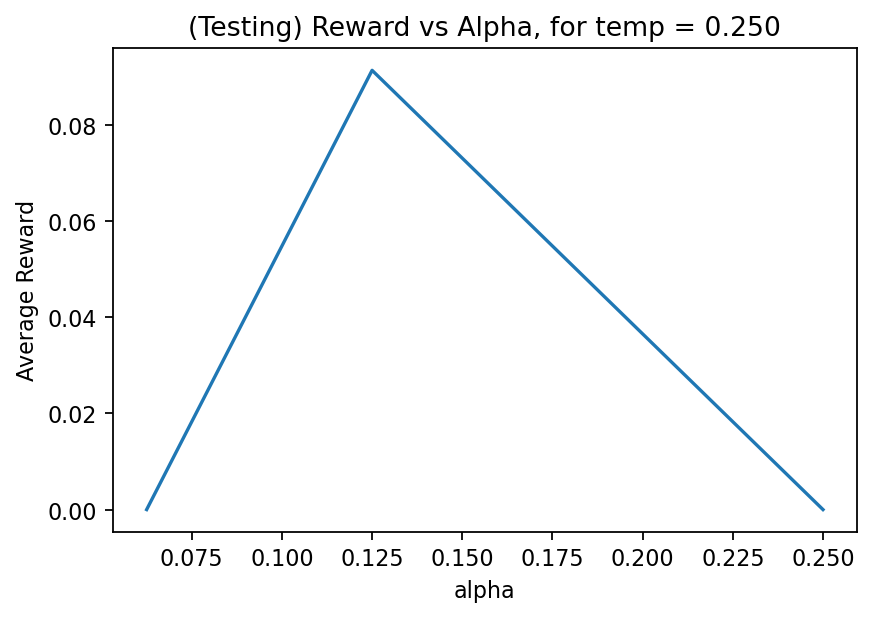

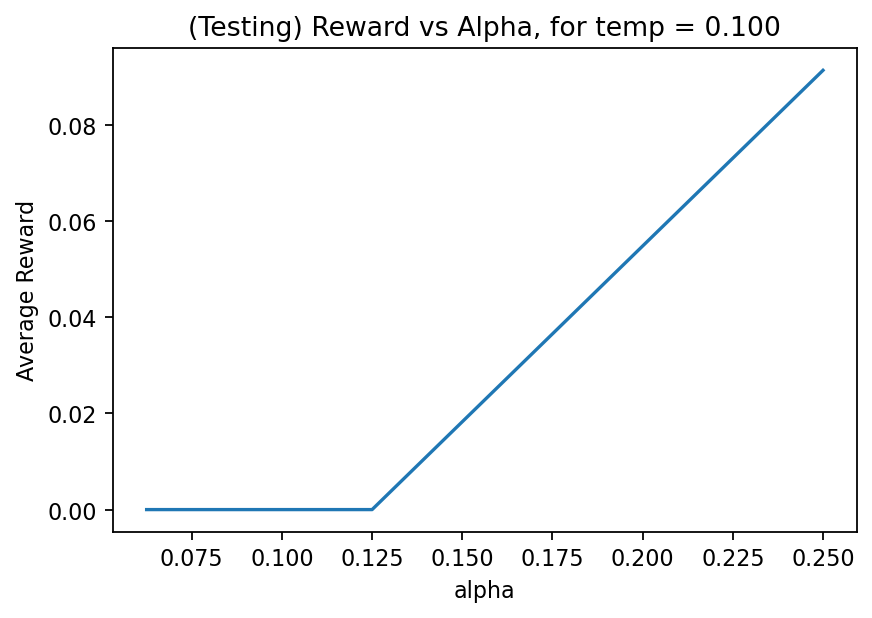

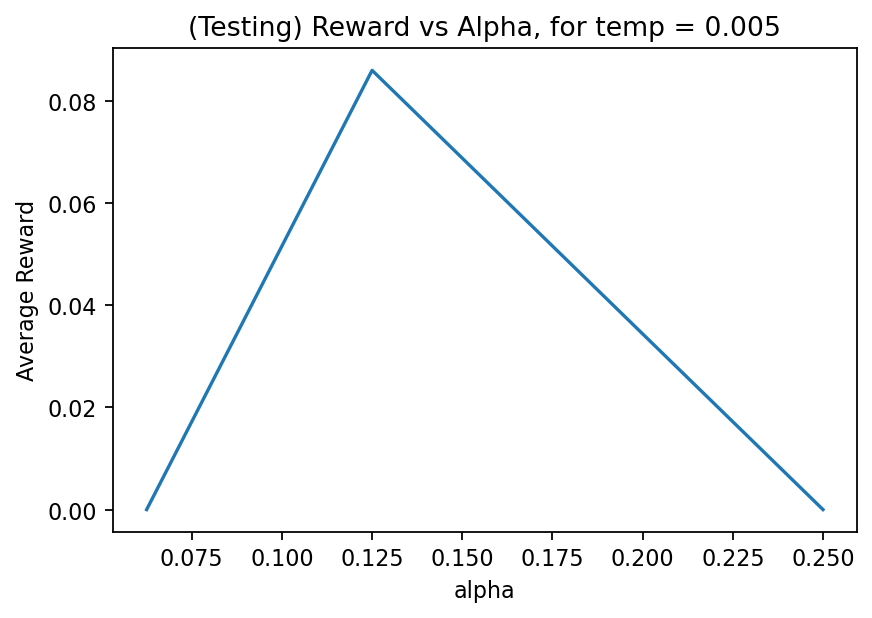

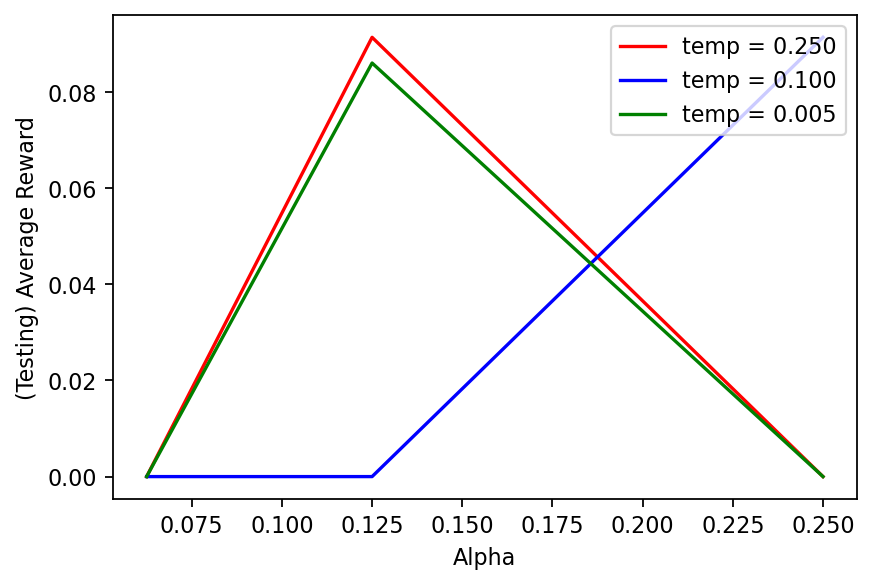

In [16]:
x_axis = []
x_axis.append(1/4)
x_axis.append(1/8)
x_axis.append(1/16)

y_axis_0 = []
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_0))
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_1))
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_2))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Alpha, for temp = 0.250")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_3))
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_4))
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_5))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Alpha, for temp = 0.100")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_6))
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_7))
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Alpha, for temp = 0.005")
plt.show()


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r')
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['temp = 0.250','temp = 0.100','temp = 0.005'])
plt.xlabel("Alpha")
plt.ylabel("(Testing) Average Reward")
plt.show()

<br>When 
    <br>temp = 0.25: we recieved the highest return at alpha = 1/8 and lowest at alpha = 1/4 and alpha = 1/16
    <br>temp = 0.10: we recieved the highest return at alpha = 1/4 and lowest at alpha = 1/8 and alpha = 1/16
    <br>temp = 0.05: we recieved the highest return at alpha = 1/8 and lowest at alpha = 1/4 and alpha = 1/16
<br>We this details we could say that the prefered value of alpha should be alpha = 1/8. Now, when we compare all the three graphs together we see that highest return is at alpha = 1/4 and temp = 0.100 and around alpha = 1/8 and temp = 0.250

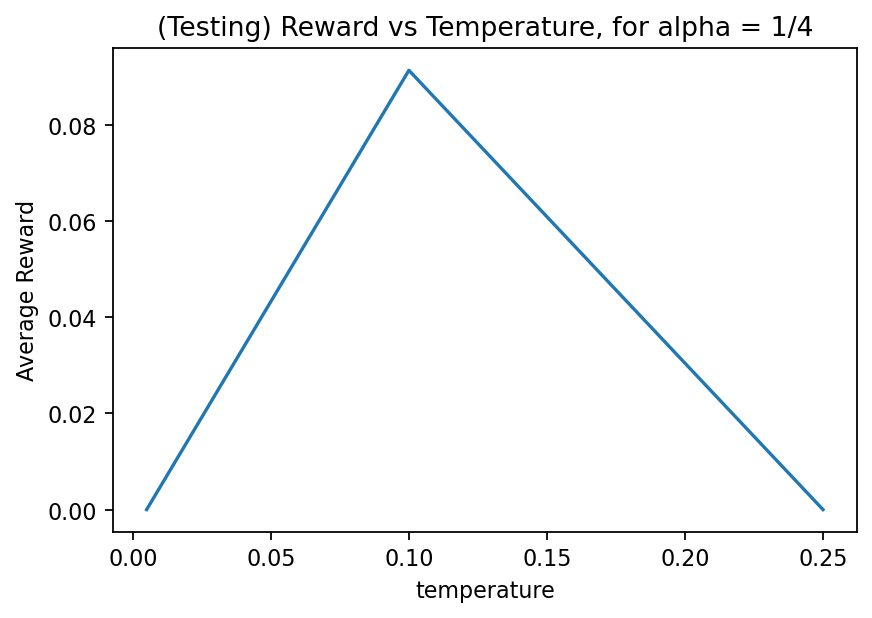

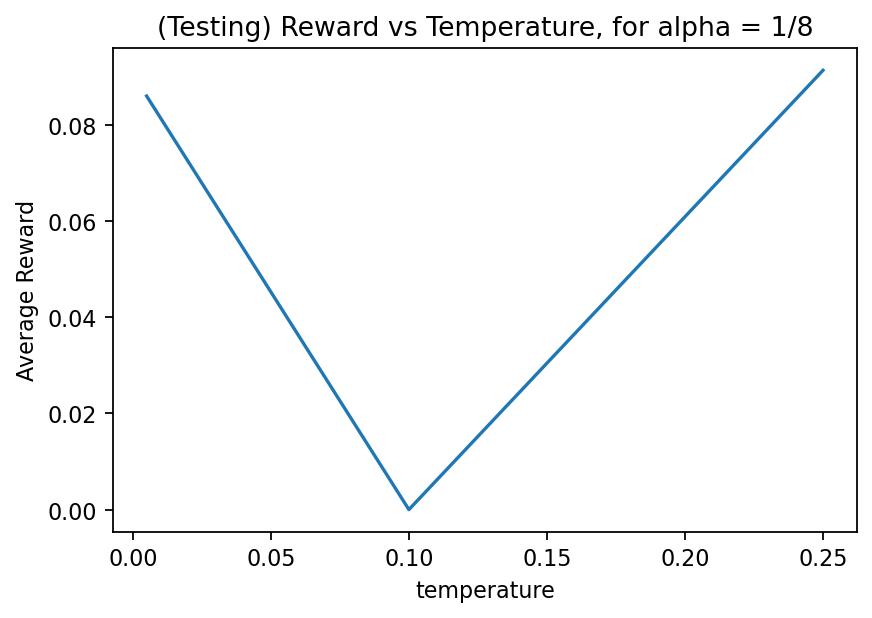

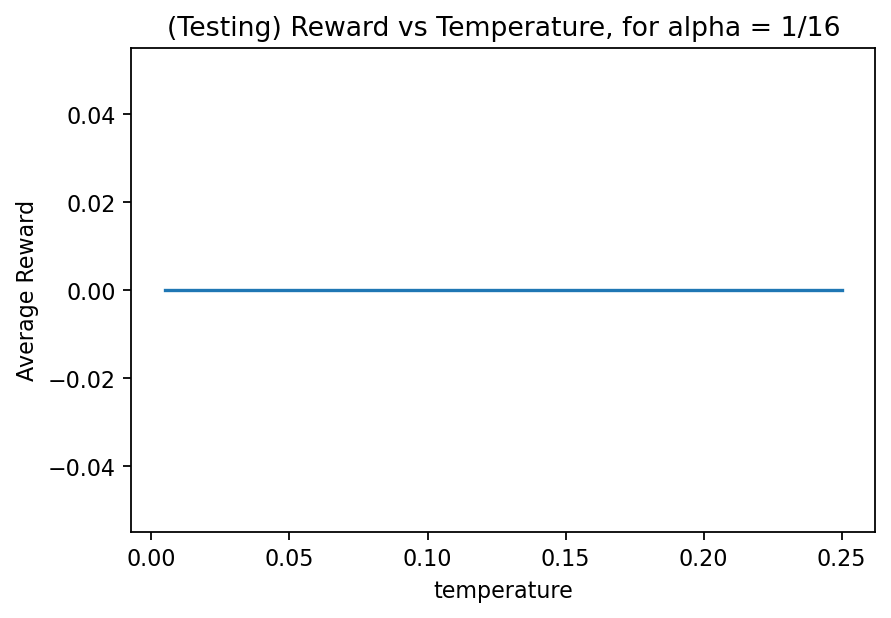

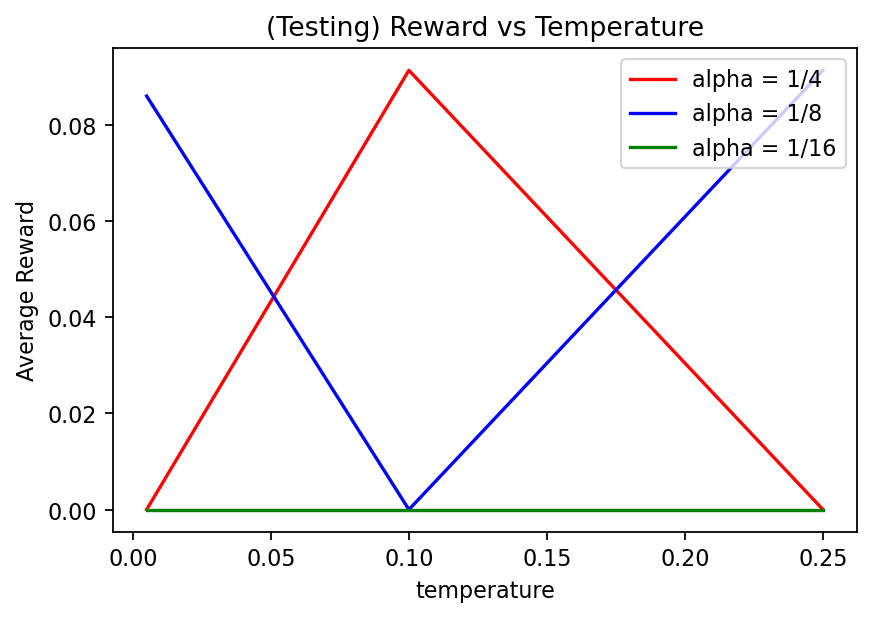

In [17]:
x_axis = []
x_axis.append(0.250)
x_axis.append(0.100)
x_axis.append(0.005)

y_axis_0 = []
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_0))
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_3))
y_axis_0.append(collect_data_2(expected_sarsa_data_dict_6))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/4")
plt.show()

y_axis_1 = []
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_1))
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_4))
y_axis_1.append(collect_data_2(expected_sarsa_data_dict_7))

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_1)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/8")
plt.show()

y_axis_2 = []
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_2))
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_5))
y_axis_2.append(collect_data_2(expected_sarsa_data_dict_8))


plt.figure(dpi=160)
plt.plot(x_axis, y_axis_2)
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature, for alpha = 1/16")
plt.show()

plt.figure(dpi=160)
plt.plot(x_axis, y_axis_0, 'r') 
plt.plot(x_axis, y_axis_1, 'b')
plt.plot(x_axis, y_axis_2, 'g') 
plt.legend(['alpha = 1/4','alpha = 1/8','alpha = 1/16'])
plt.xlabel("temperature")
plt.ylabel("Average Reward")
plt.title("(Testing) Reward vs Temperature")
plt.show()

<br>When 
    <br>alpha = 1/4: we recieved the highest return at temp = 0.100 and lowest at temp = 0.250 and temp = 0.005
    <br>alpha = 1/8: we recieved the highest return at temp = 0.250 and temp = 0.05 and lowest at temp = 0.100
    <br>alpha = 1/16: we recieved zero for all the three values of temp
<br>Now, when we compare all the graphs together we see that the highest return was observed at alpha = 1/8 and temp = 0.250 and at alpha = 1/4 and temp = 0.100

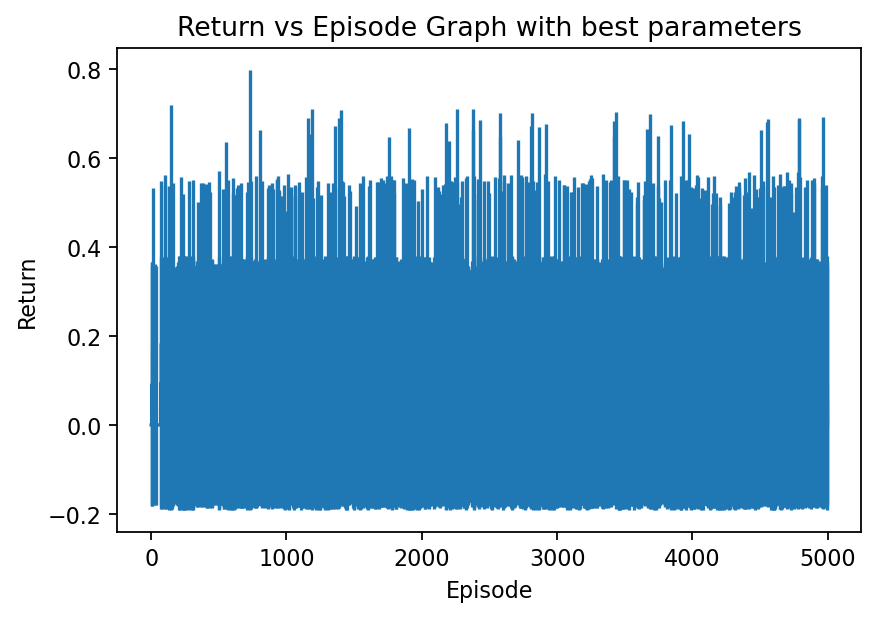

In [32]:
mean_array, sd_array = collect_data_3(expected_sarsa_all_epi_7)
x = list(range(len(mean_array)))
plt.figure(dpi=160)
plt.errorbar(x, mean_array, yerr=sd_array)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode Graph with best parameters")
plt.show()

For we see the entire learning graph with the best parameters (i.e. temp = 0.5 and alpha = 1/16) we obeserve that the average episode ruturn is aprroximately similar (0.20) and does change over the run.

# **Q Learning**

I am implemented the following program to analyse Q-learning algorithm performance over cartpole environment. There are 10 different run and in each of these runs there are 1000 epsidoes where the action is selected based on greedy epsilon exploration.

**CARTPOLE environment**

In [19]:
env = gym.make('CartPole-v1')

**Hyperparameters**

**Defining Dicrete Bins**
<br>For each observation element (Posiiton, Velocity, Angle and Angular-Velcity) we difine 10 equal range/size bins (from 0 to 9). 
<br>This is done by dividing the whole range (max value - min value) of each elements by 10. (I got these max and min value from the environment, for varification I have ran the experiment 10^6 time with random action).
<br>We then define state in a form of tuple of length = 4, where index
<br>0 -> Posiiton
<br>1 -> Velocity
<br>2 -> Angle
<br>3 -> Angular-velcity
<br>Now, each state could take two actions (i.e. 0 or 1)

**Methods to create defination discrete bins (to be used by Q-learning)**

In [20]:
POSITION_HIGH = 4.800
POSITION_LOW = -4.800
VELOCITY_HIGH = 3.402
VELOCITY_LOW = -3.402
ANGLE_HIGH = 4.188
ANGLE_LOW = -4.188
ANGLE_VELOCITY_HIGH = 3.402
ANGLE_VELOCITY_LOW = -3.402

"""
Method create bin information dictionay that defines the descrete bins,
which is used to define state
"""
def get_bins_def():
    bins_dict = {}
    start_pos = POSITION_LOW
    start_vel = VELOCITY_LOW
    start_ang = ANGLE_LOW
    start_ang_vel = ANGLE_VELOCITY_LOW
    range_pos = (POSITION_HIGH - POSITION_LOW) / 10
    range_vel = (VELOCITY_HIGH - VELOCITY_LOW) / 10
    range_ang = (ANGLE_HIGH - ANGLE_LOW) / 10
    range_ang_vel = (ANGLE_VELOCITY_HIGH - ANGLE_VELOCITY_LOW) / 10
    for bin in range(10):
        end_pos = start_pos + range_pos
        end_vel = start_vel + range_vel
        end_ang = start_ang + range_ang
        end_ang_vel = start_ang_vel + range_ang_vel
        bins_dict[bin] = {"pos_low": start_pos, 
                          "pos_high": end_pos, 
                          "vel_low": start_vel,
                          "vel_high": end_vel,
                          "ang_low": start_ang,
                          "ang_high": end_ang,
                          "ang_vel_low": start_ang_vel, 
                          "ang_vel_high": end_ang_vel}
        start_pos = start_pos + range_pos #+ 0.0001
        start_vel = start_vel + range_vel #+ 0.0001
        start_ang = start_ang + range_ang #+ 0.0001
        start_ang_vel = start_ang_vel + range_ang_vel #+ 0.0001
    return bins_dict

"""
The method returns the state (tuple) based on bin information, for given state,
"""
def get_bin_ind(array, bin_def):
    pos_bin = -1
    pos = round(array[0],2)
    for bins in bin_def:
        if pos <= bin_def[bins]["pos_high"]:# and pos >= bin_def[bins]["pos_low"]:
            pos_bin = bins
            break
    if pos_bin == -1:
        pos_bin = 9
    
    vel_bin = -1
    vel = round(array[1],2)
    for bins in bin_def:
        if vel <= bin_def[bins]["vel_high"]:# and vel >= bin_def[bins]["vel_low"]:
            vel_bin = bins
            break
    if vel_bin == -1:
        vel_bin = 9
    
    ang_bin = -1
    ang = round(array[2],2)
    for bins in bin_def:
        if ang <= bin_def[bins]["ang_high"]:# and ang >= bin_def[bins]["ang_low"]:
            ang_bin = bins
            break
    if ang_bin == -1:
        ang_bin = 9
    
    ang_vel_bin = -1
    ang_vel = round(array[3],2)
    for bins in bin_def:
        if ang_vel <= bin_def[bins]["ang_vel_high"]:# and ang_vel >= bin_def[bins]["ang_vel_low"]:
            ang_vel_bin = bins
            break
    if ang_vel_bin == -1:
        ang_vel_bin = 9
        
    return (pos_bin, vel_bin, ang_bin, ang_vel_bin)
    
bin_def = get_bins_def()

**Methods to analyse collected data (Q learning)**
We, first, collected return of each 1000 episodes
and then take average (for each episode) over 10 independent runs

In [21]:
def collect_data_q_learning(data_dict):
    main_dict = []
    for ind in range(1000):
        avg = 0
        for n_run in range(10):
            avg = avg + data_dict[n_run][ind]
        avg = avg / 10
        main_dict.append(avg)
    return main_dict

**Methods to run Q-learning algorithm**

In [22]:
"""
Run 1000 episodes with linear approximation
Exploration: Greedy Epsilon
"""
def run_epidodes_q_learing(Q, alpha, epsilon): 
    return_array = []
    for episode_n in range(1000):
        # For Data collection
        training_return = 0
        iter_n = 0
        # Starting state
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        if state not in Q.keys():
            Q[state] = [0.0, 0.0]
        # loop variables
        terminated = False
        truncated = False
        while(True):
            # Current Action based on greedy exploration policy
            action = choose_action_Q_learning(Q, state, epsilon)
            # Next state
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = get_bin_ind(observation, bin_def)
            if next_state not in Q.keys():
                Q[next_state] = [0.0, 0.0]
                
            #updating the Q value
            cur_state_value = Q[state][action]
            next_state_value = get_max_state_action_value(Q, next_state)
            target = reward + (gamma * next_state_value)
            Q[state][action] = Q[state][action] + alpha * (target - cur_state_value)
            
            # updating state
            state = next_state
            
            # Collecting data
            training_return = training_return + (reward * (pow(discount_factor,iter_n)))
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
                
        return_array.append(training_return)  
    return return_array

"""
Method to choose Action based on Greedy Epsilon exploration
"""
def choose_action_Q_learning(Q, state, epsilon):
    max_action = -1
    if Q[state][0] > Q[state][1]:
        max_action = 0
    elif Q[state][0] < Q[state][1]:
        max_action = 1
    else:
        max_action = random.randint(0, 1)
    exploit = np.random.binomial(1, 1-epsilon)
    if exploit:
        return max_action
    else:
        return random.randint(0, 1)

"""
Method to get the best (max) action value for next state
"""
def get_max_state_action_value(Q, state):
    if Q[state][0] > Q[state][1]:
        return Q[state][0]
    elif Q[state][0] < Q[state][1]:
        return Q[state][1]
    else:
        return Q[state][0]

"""
Run 10 independent runs
"""
def run_algo_q_learing(alpha, epsilon):
    main_dict = {}
    for n in range(10):
        Q = {}
        main_dict[n] = run_epidodes_q_learing(Q, alpha, epsilon)
    print("Independent Run Completed ")
    return main_dict

**Collecting data for analysis (Q learning)**
<br>For alpha the values 1/4, 1/8 and 1/16 (given)
<br>For epsilon the values are 0.65, 0.80, and 0.95 (In assignment 1, I got the best return when epsilon was 1-0.80 therefore I emphasis it here with +- 10)

In [23]:
gamma = 0.99
discount_factor = 0.99

In [24]:
q_learning_data_dict_0 = run_algo_q_learing(1/4, 0.35)
q_learning_data_dict_1 = run_algo_q_learing(1/4, 0.20)
q_learning_data_dict_2 = run_algo_q_learing(1/4, 0.05)
q_learning_data_dict_3 = run_algo_q_learing(1/8, 0.35)
q_learning_data_dict_4 = run_algo_q_learing(1/8, 0.20)
q_learning_data_dict_5 = run_algo_q_learing(1/8, 0.05)
q_learning_data_dict_6 = run_algo_q_learing(1/16, 0.35)
q_learning_data_dict_7 = run_algo_q_learing(1/16, 0.20)
q_learning_data_dict_8 = run_algo_q_learing(1/16, 0.05)

Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 
Independent Run Completed 


**Plot for collected and analysed data (Q learning)**

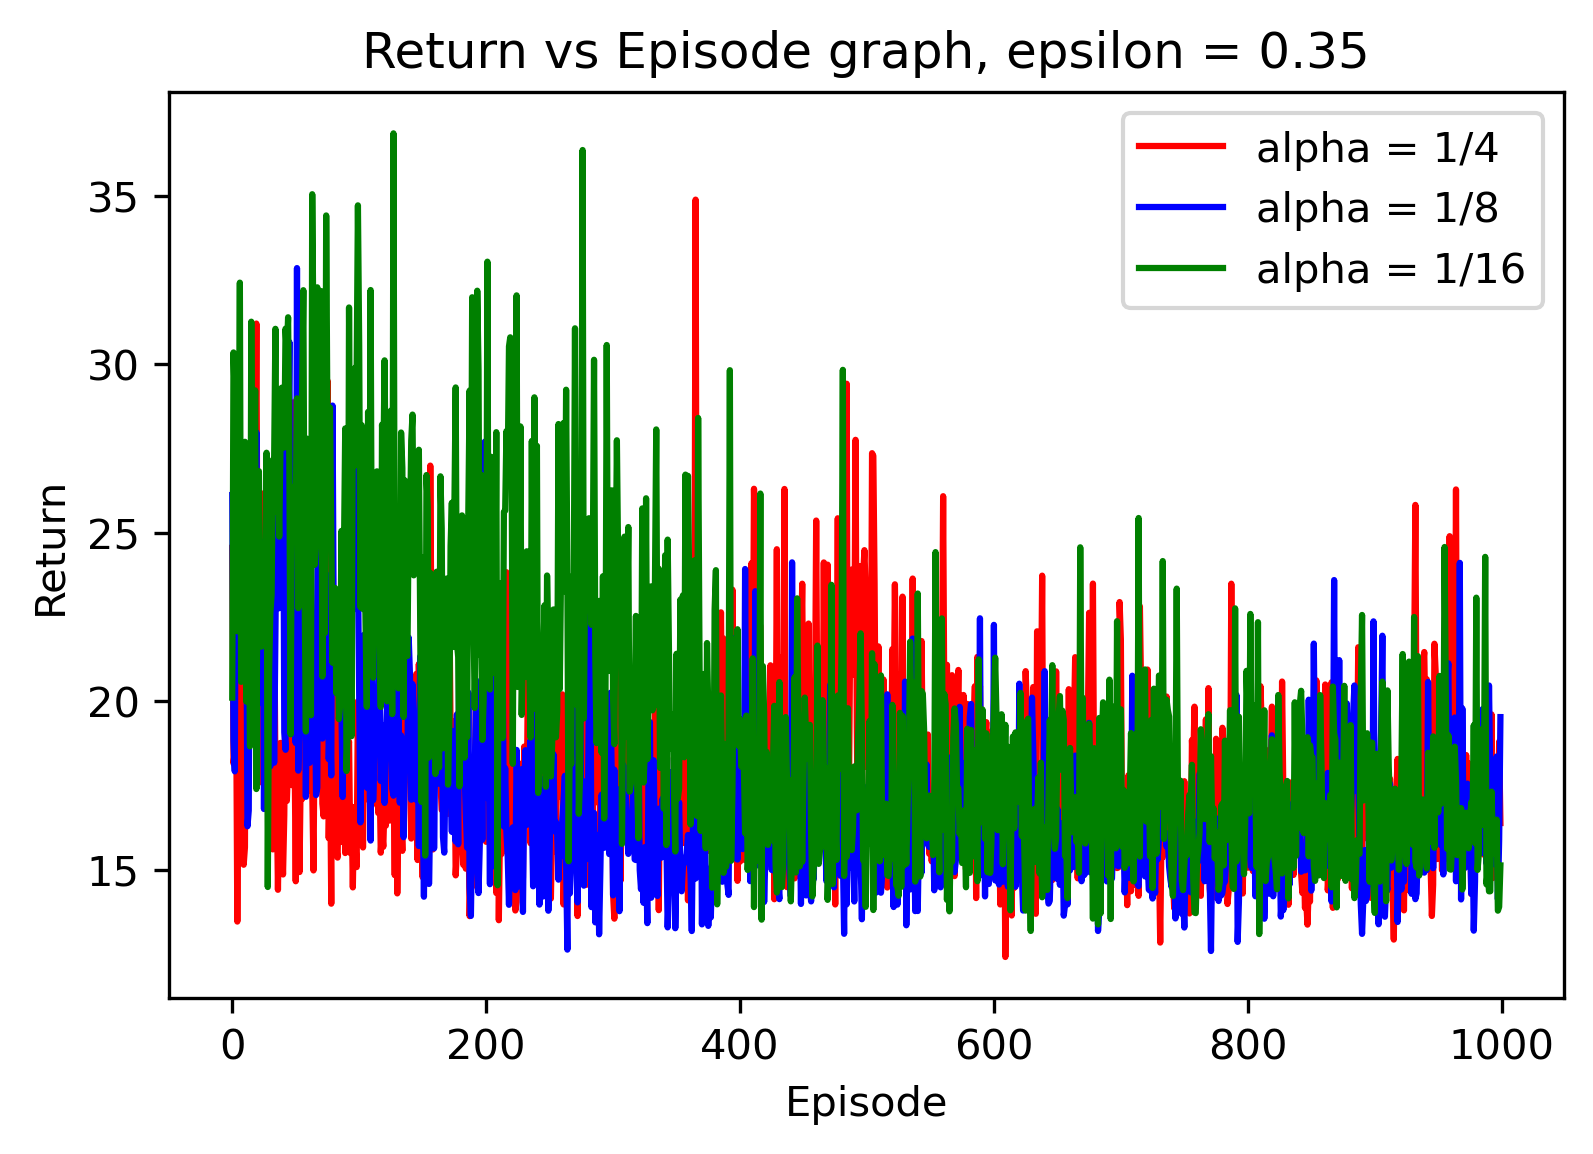

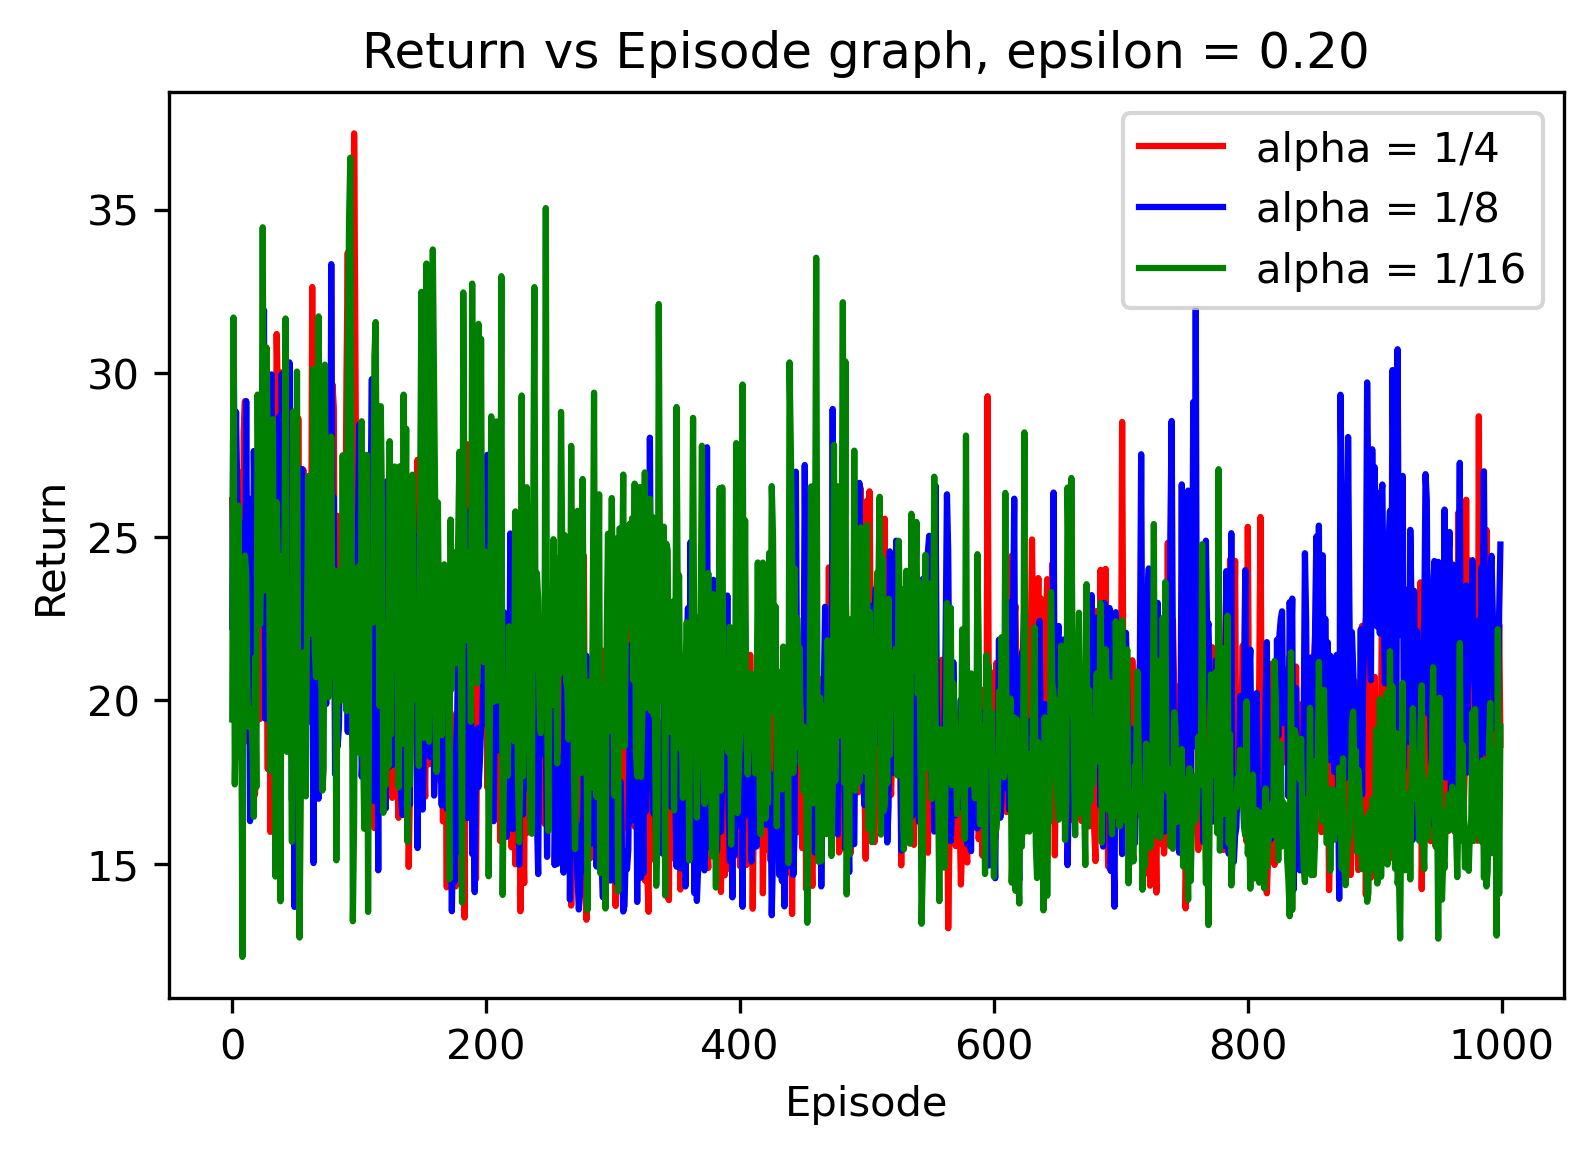

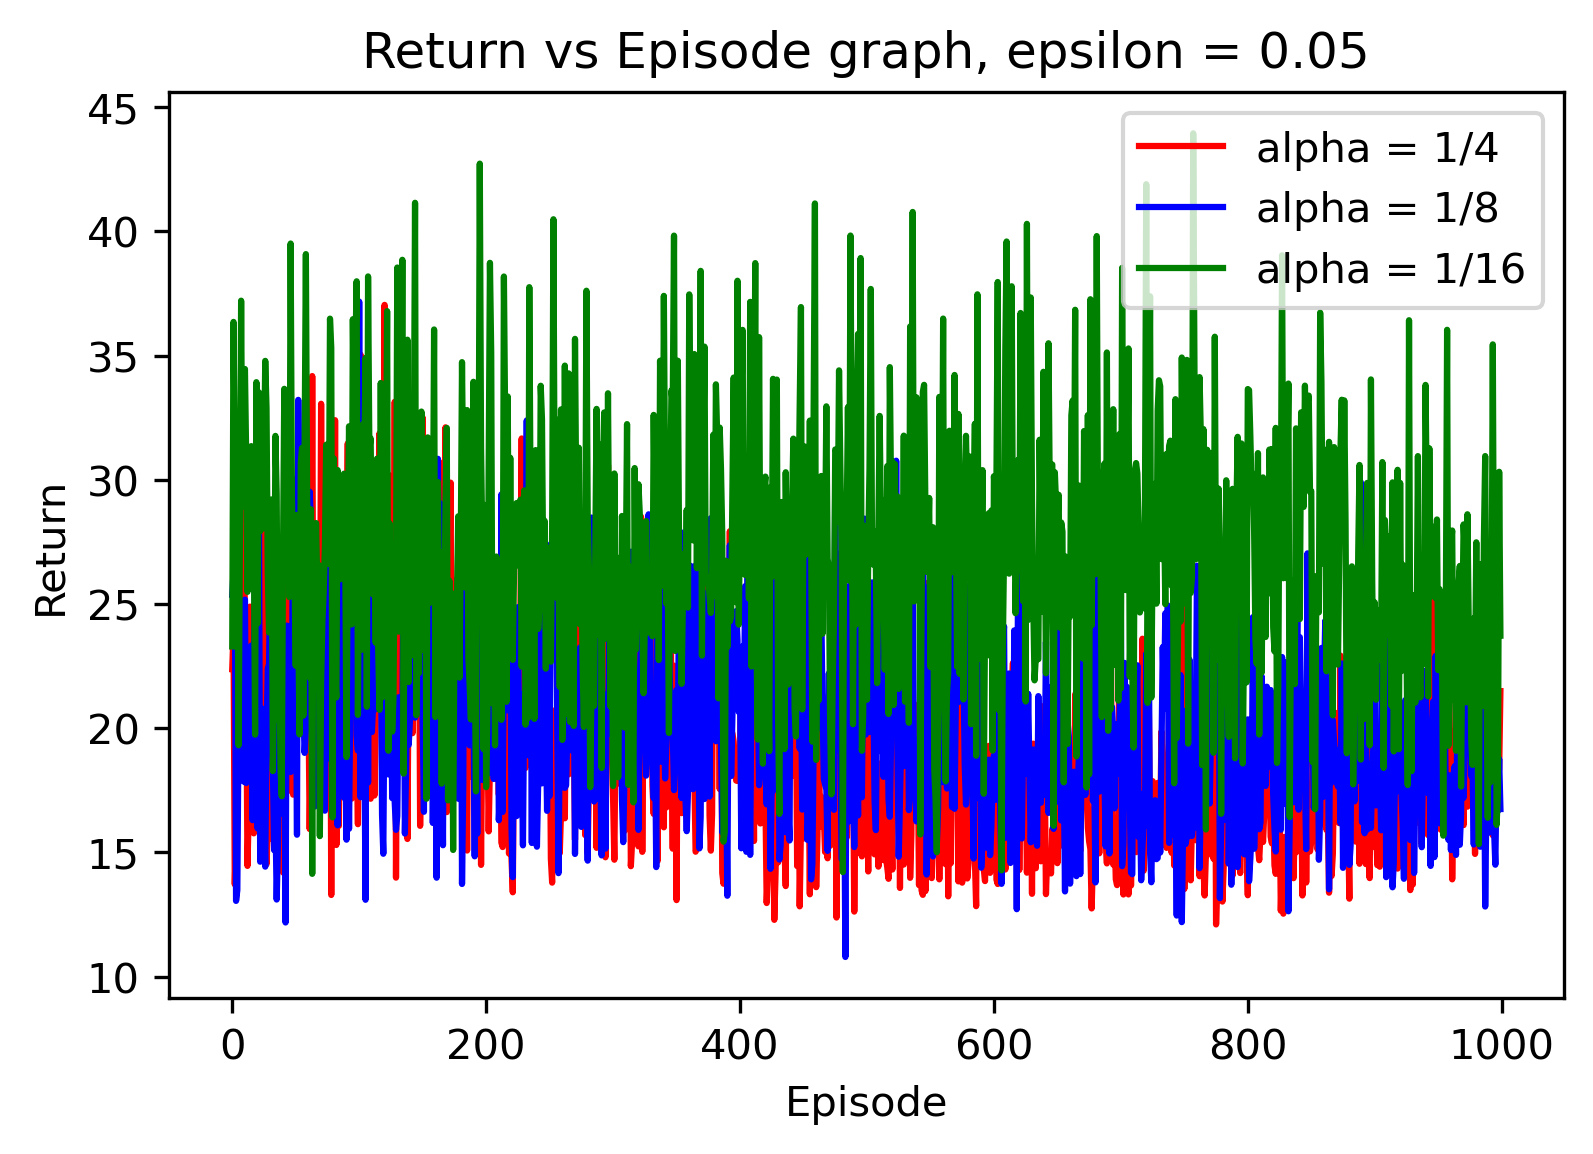

In [25]:
plt.figure(dpi=300)
plt.plot(collect_data_q_learning(q_learning_data_dict_0), 'r')
plt.plot(collect_data_q_learning(q_learning_data_dict_3), 'b')
plt.plot(collect_data_q_learning(q_learning_data_dict_6), 'g')
plt.legend(['alpha = 1/4', 'alpha = 1/8', 'alpha = 1/16'])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode graph, epsilon = 0.35")
plt.show()

plt.figure(dpi=300)
plt.plot(collect_data_q_learning(q_learning_data_dict_1), 'r')
plt.plot(collect_data_q_learning(q_learning_data_dict_4), 'b')
plt.plot(collect_data_q_learning(q_learning_data_dict_7), 'g')
plt.legend(['alpha = 1/4', 'alpha = 1/8', 'alpha = 1/16'])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode graph, epsilon = 0.20")
plt.show()


plt.figure(dpi=300)
plt.plot(collect_data_q_learning(q_learning_data_dict_2), 'r')
plt.plot(collect_data_q_learning(q_learning_data_dict_5), 'b')
plt.plot(collect_data_q_learning(q_learning_data_dict_8), 'g')
plt.legend(['alpha = 1/4', 'alpha = 1/8', 'alpha = 1/16'])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode graph, epsilon = 0.05")
plt.show()

<br>When 
<br>epsilon = 0.35: we obeserve that for alpha = 1/16 and alpha = 1/8 the return values dip from 0 to 500th episode than then it remains the same, whereelse for alpha = 1/4 it does change over the run
<br>epsilon = 0.20 we obeserve that the return values for all the three alpha values shows dip till, however for alpha = 1/8 and alpha = 1/4 the return value increases slightly towards the end of the run
<br>epsilon = 0.05: The return values for all the three values of alpha does change over the run, however alpha = 1/16 perform better than other.

# Action-Critic (with linear approximation function)

I am implemented program to analyse Q-learning algorithm with linear approximation performance over cartpole environment.. There 10 different run and in each of these runs there are 1000 epsidoes where the action is selected based on Softmax exploration.

The defination of discrete bins is same as Q - learning

**Method to create Q - value table for state**

In [26]:
"""
This method return a predefine Q_value table for all the possible state (10^4) according to discrete bin defination
"""
def get_Q_AC():
    for a in range(10):
        for b in range(10):
            for c in range(10):
                for d in range(10):
                    Q[(a,b,c,d)] = {"weight": random.uniform(-0.001,0.001), "Action_Value": [0.0, 0.0]}
    return Q

**Method to run Action-Critic**

In [27]:
"""
run 1000 episodes with different starting state
"""
def run_episodes_AC(Q, temp):
    return_array = []
    for n in range(1000):
        training_return = 0
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        if state not in Q.keys():
            Q[state] = {"weight": random.uniform(-0.001,0.001), "Action_Value": [0.0, 0.0]}
        truncated = False
        terminated = False
        iter_n = 0
        while(True):
            action, prob_softmax = choose_action_AC(Q, state, temp)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = get_bin_ind(observation, bin_def)
            
            training_return = training_return + reward * (discounting_factor ** iter_n) 
            
            if next_state not in Q.keys():
                Q[next_state] = {"weight": random.uniform(-0.001,0.001), "Action_Value": [0.0, 0.0]}
            
            
            delta = reward + gamma * Q[next_state]["weight"] - Q[state]["weight"]
            
            Q[state]["weight"] = Q[state]["weight"] + alpha_weight * delta
            for act in [0,1]:
                if act == action:
                    Q[state]["Action_Value"][act] = Q[state]["Action_Value"][act] + alpha_act_val * delta * (1 - prob_softmax[act])
                else:
                    Q[state]["Action_Value"][act] = Q[state]["Action_Value"][act] + alpha_act_val * delta * (0 - prob_softmax[act])
            state = next_state  
            iter_n = iter_n + 1
            
            if truncated or terminated:
                break
        return_array.append(training_return)
    return return_array
  
"""
Choose action based on softmax exploration for given state
"""
def choose_action_AC(Q, state, temp):
    prob_q = {}
    prob_q[0] = math.exp(Q[state]["Action_Value"][0]/temp) / (math.exp(Q[state]["Action_Value"][0]/temp) + math.exp(Q[state]["Action_Value"][1]/temp))
    prob_q[1] = math.exp(Q[state]["Action_Value"][1]/temp) / (math.exp(Q[state]["Action_Value"][0]/temp) + math.exp(Q[state]["Action_Value"][1]/temp))
    return np.random.choice([0,1], p = [prob_q[0], prob_q[1]]), [prob_q[0], prob_q[1]] 

"""
run 10 independent run
"""
def run_algo_AC(temp):
    main_data = []
    iter_n = 0
    for n in range(10):
        Q =  {}
        main_data.append(run_episodes_AC(Q, temp))
        print("Independent Run: " + str(iter_n))
        iter_n = iter_n + 1
    return main_data

"""
Method to average the return of each episode over 10 independent run
"""
def compute_avg(array):
    result = []
    for ind in range(1000):
        avg = 0
        for n in range(10):
            avg = avg + array[n][ind]
        avg = avg / 10
        result.append(avg)
    return result

**Hyperparameter** 
All of the follwing parameters are choosen to be less than 1 but very close to 1.

In [28]:
gamma = 0.99
discounting_factor = 0.99
alpha_weight = 0.99
alpha_act_val = 0.99

**Collecting data (Action-Critic)** 
<br> I have test temperature values temp = 100, temp = 50 and temp = 0.1. This is done to see temp effect all all sort of range 

In [29]:
ac_data_dict_0 = run_algo_AC(100)
ac_data_dict_1 = run_algo_AC(50)
ac_data_dict_2 = run_algo_AC(0.1)

Independent Run: 0
Independent Run: 1
Independent Run: 2
Independent Run: 3
Independent Run: 4
Independent Run: 5
Independent Run: 6
Independent Run: 7
Independent Run: 8
Independent Run: 9
Independent Run: 0
Independent Run: 1
Independent Run: 2
Independent Run: 3
Independent Run: 4
Independent Run: 5
Independent Run: 6
Independent Run: 7
Independent Run: 8
Independent Run: 9
Independent Run: 0
Independent Run: 1
Independent Run: 2
Independent Run: 3
Independent Run: 4
Independent Run: 5
Independent Run: 6
Independent Run: 7
Independent Run: 8
Independent Run: 9


**Plottting graph to analyse the perforamce of Action-Critic**

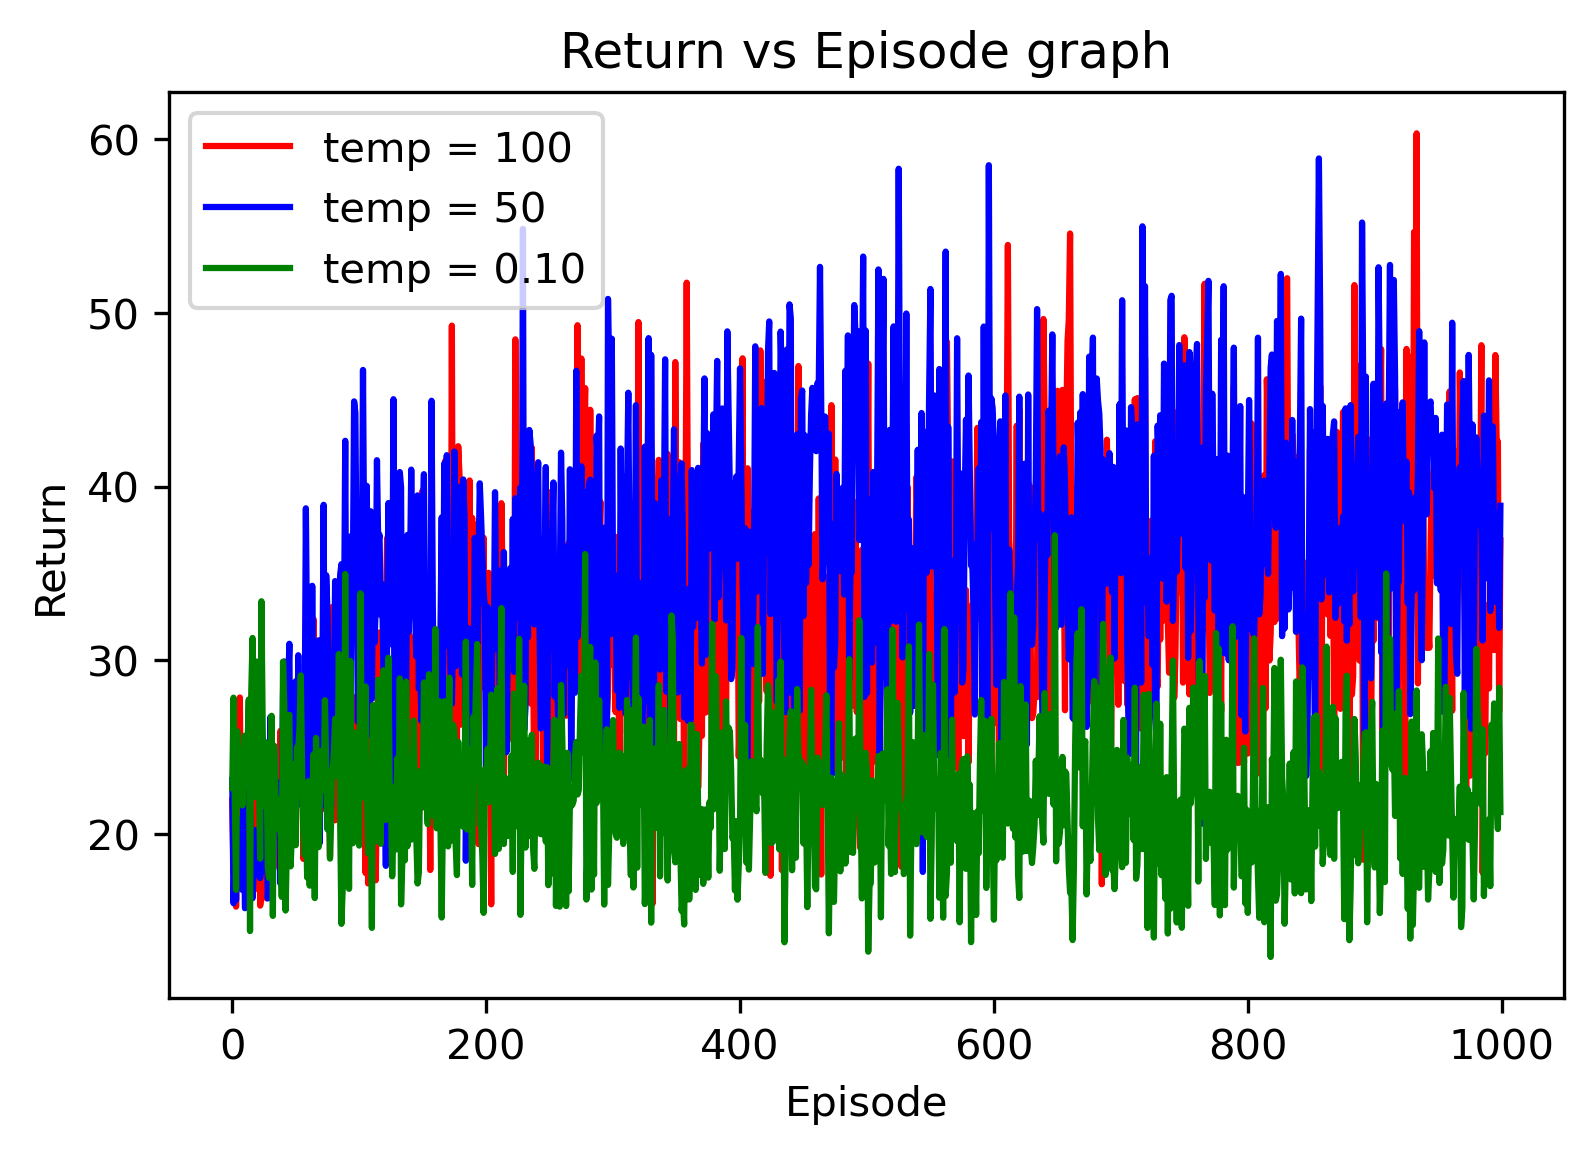

In [30]:
plt.figure(dpi=300)
plt.plot(compute_avg(ac_data_dict_0), 'r')
plt.plot(compute_avg(ac_data_dict_1), 'b')
plt.plot(compute_avg(ac_data_dict_2), 'g')
plt.legend(['temp = 100', 'temp = 50', 'temp = 0.10'])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return vs Episode graph")
plt.show()

For temp = 0.10, the average return values of episodes reamins the same throughout the run, for temp = 50, the average return values of episodes increases till 400th episode ans then it remains the same, lastly, for temp = 100, as well, the average return values increases and then it converges to a value.